# load library

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Mar 22 00:46:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    49W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
!pip install torchnet

In [1]:
#torch

from torch.nn import Parameter
import torch
import torch.optim
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F

import torchvision.models as models
import torchvision.transforms as transforms

import torch.utils.data as Data
import torch.backends.cudnn as cudnn


#torchnet???
#import torchnet as tnt


#numpy
import numpy as np

#pandas
import pandas as pd

#utility

import math
from urllib.request import urlretrieve

from PIL import Image
#from tqdm import tqdm
from tqdm.auto import tqdm
import random

import json
import os
import pickle
import shutil
import time


#initialize hyperparameter

In [3]:
use_gpu = torch.cuda.is_available()

image_size = 224

batch_size = 64

num_classes = 23

#workers = 25
workers = 2

device_ids = None

evaluate = False

start_epoch = 0

max_epochs = 90

epoch_step = []

use_pb = True

best_score= 0

# define utility class & function

In [4]:
class Warp(object):
    def __init__(self, size, interpolation=Image.BILINEAR):
        self.size = int(size)
        self.interpolation = interpolation

    def __call__(self, img):
        return img.resize((self.size, self.size), self.interpolation)

    def __str__(self):
        return self.__class__.__name__ + ' (size={size}, interpolation={interpolation})'.format(size=self.size,
                                                                                                interpolation=self.interpolation)
class MultiScaleCrop(object):

    def __init__(self, input_size, scales=None, max_distort=1, fix_crop=True, more_fix_crop=True):
        self.scales = scales if scales is not None else [1, 875, .75, .66]
        self.max_distort = max_distort
        self.fix_crop = fix_crop
        self.more_fix_crop = more_fix_crop
        self.input_size = input_size if not isinstance(input_size, int) else [input_size, input_size]
        self.interpolation = Image.BILINEAR

    def __call__(self, img):
        im_size = img.size
        crop_w, crop_h, offset_w, offset_h = self._sample_crop_size(im_size)
        crop_img_group = img.crop((offset_w, offset_h, offset_w + crop_w, offset_h + crop_h))
        ret_img_group = crop_img_group.resize((self.input_size[0], self.input_size[1]), self.interpolation)
        return ret_img_group

    def _sample_crop_size(self, im_size):
        image_w, image_h = im_size[0], im_size[1]

        # find a crop size
        base_size = min(image_w, image_h)
        crop_sizes = [int(base_size * x) for x in self.scales]
        crop_h = [self.input_size[1] if abs(x - self.input_size[1]) < 3 else x for x in crop_sizes]
        crop_w = [self.input_size[0] if abs(x - self.input_size[0]) < 3 else x for x in crop_sizes]

        pairs = []
        for i, h in enumerate(crop_h):
            for j, w in enumerate(crop_w):
                if abs(i - j) <= self.max_distort:
                    pairs.append((w, h))

        crop_pair = random.choice(pairs)
        if not self.fix_crop:
            w_offset = random.randint(0, image_w - crop_pair[0])
            h_offset = random.randint(0, image_h - crop_pair[1])
        else:
            w_offset, h_offset = self._sample_fix_offset(image_w, image_h, crop_pair[0], crop_pair[1])

        return crop_pair[0], crop_pair[1], w_offset, h_offset

    def _sample_fix_offset(self, image_w, image_h, crop_w, crop_h):
        offsets = self.fill_fix_offset(self.more_fix_crop, image_w, image_h, crop_w, crop_h)
        return random.choice(offsets)

    @staticmethod
    def fill_fix_offset(more_fix_crop, image_w, image_h, crop_w, crop_h):
        w_step = (image_w - crop_w) // 4
        h_step = (image_h - crop_h) // 4

        ret = list()
        ret.append((0, 0))  # upper left
        ret.append((4 * w_step, 0))  # upper right
        ret.append((0, 4 * h_step))  # lower left
        ret.append((4 * w_step, 4 * h_step))  # lower right
        ret.append((2 * w_step, 2 * h_step))  # center

        if more_fix_crop:
            ret.append((0, 2 * h_step))  # center left
            ret.append((4 * w_step, 2 * h_step))  # center right
            ret.append((2 * w_step, 4 * h_step))  # lower center
            ret.append((2 * w_step, 0 * h_step))  # upper center

            ret.append((1 * w_step, 1 * h_step))  # upper left quarter
            ret.append((3 * w_step, 1 * h_step))  # upper right quarter
            ret.append((1 * w_step, 3 * h_step))  # lower left quarter
            ret.append((3 * w_step, 3 * h_step))  # lower righ quarter

        return ret


    def __str__(self):
        return self.__class__.__name__


def download_url(url, destination=None, progress_bar=True):
    """Download a URL to a local file.

    Parameters
    ----------
    url : str
        The URL to download.
    destination : str, None
        The destination of the file. If None is given the file is saved to a temporary directory.
    progress_bar : bool
        Whether to show a command-line progress bar while downloading.

    Returns
    -------
    filename : str
        The location of the downloaded file.

    Notes
    -----
    Progress bar use/example adapted from tqdm documentation: https://github.com/tqdm/tqdm
    """

    def my_hook(t):
        last_b = [0]

        def inner(b=1, bsize=1, tsize=None):
            if tsize is not None:
                t.total = tsize
            if b > 0:
                t.update((b - last_b[0]) * bsize)
            last_b[0] = b

        return inner

    if progress_bar:
        with tqdm(unit='B', unit_scale=True, miniters=1, desc=url.split('/')[-1]) as t:
            filename, _ = urlretrieve(url, filename=destination, reporthook=my_hook(t))
    else:
        filename, _ = urlretrieve(url, filename=destination)


class AveragePrecisionMeter(object):
    """
    The APMeter measures the average precision per class.
    The APMeter is designed to operate on `NxK` Tensors `output` and
    `target`, and optionally a `Nx1` Tensor weight where (1) the `output`
    contains model output scores for `N` examples and `K` classes that ought to
    be higher when the model is more convinced that the example should be
    positively labeled, and smaller when the model believes the example should
    be negatively labeled (for instance, the output of a sigmoid function); (2)
    the `target` contains only values 0 (for negative examples) and 1
    (for positive examples); and (3) the `weight` ( > 0) represents weight for
    each sample.
    """

    def __init__(self, difficult_examples=False):
        super(AveragePrecisionMeter, self).__init__()
        self.reset()
        self.difficult_examples = difficult_examples

    def reset(self):
        """Resets the meter with empty member variables"""
        self.scores = torch.FloatTensor(torch.FloatStorage())
        self.targets = torch.LongTensor(torch.LongStorage())

    def add(self, output, target):
        """
        Args:
            output (Tensor): NxK tensor that for each of the N examples
                indicates the probability of the example belonging to each of
                the K classes, according to the model. The probabilities should
                sum to one over all classes
            target (Tensor): binary NxK tensort that encodes which of the K
                classes are associated with the N-th input
                    (eg: a row [0, 1, 0, 1] indicates that the example is
                         associated with classes 2 and 4)
            weight (optional, Tensor): Nx1 tensor representing the weight for
                each example (each weight > 0)
        """
        if not torch.is_tensor(output):
            output = torch.from_numpy(output)
        if not torch.is_tensor(target):
            target = torch.from_numpy(target)

        if output.dim() == 1:
            output = output.view(-1, 1)
        else:
            assert output.dim() == 2, \
                'wrong output size (should be 1D or 2D with one column \
                per class)'
        if target.dim() == 1:
            target = target.view(-1, 1)
        else:
            assert target.dim() == 2, \
                'wrong target size (should be 1D or 2D with one column \
                per class)'
        if self.scores.numel() > 0:
            assert target.size(1) == self.targets.size(1), \
                'dimensions for output should match previously added examples.'

        # make sure storage is of sufficient size
        if self.scores.storage().size() < self.scores.numel() + output.numel():
            new_size = math.ceil(self.scores.storage().size() * 1.5)
            self.scores.storage().resize_(int(new_size + output.numel()))
            self.targets.storage().resize_(int(new_size + output.numel()))

        # store scores and targets
        offset = self.scores.size(0) if self.scores.dim() > 0 else 0
        self.scores.resize_(offset + output.size(0), output.size(1))
        self.targets.resize_(offset + target.size(0), target.size(1))
        self.scores.narrow(0, offset, output.size(0)).copy_(output)
        self.targets.narrow(0, offset, target.size(0)).copy_(target)

    def value(self):
        """Returns the model's average precision for each class
        Return:
            ap (FloatTensor): 1xK tensor, with avg precision for each class k
        """

        if self.scores.numel() == 0:
            return 0
        ap = torch.zeros(self.scores.size(1))
        rg = torch.arange(1, self.scores.size(0)).float()
        # compute average precision for each class
        for k in range(self.scores.size(1)):
            # sort scores
            scores = self.scores[:, k]
            targets = self.targets[:, k]
            # compute average precision
            ap[k] = AveragePrecisionMeter.average_precision(scores, targets, self.difficult_examples)
        return ap

    @staticmethod
    def average_precision(output, target, difficult_examples=True):

        # sort examples
        sorted, indices = torch.sort(output, dim=0, descending=True)

        # Computes prec@i
        pos_count = 0.
        total_count = 0.
        precision_at_i = 0.
        for i in indices:
            label = target[i]
            if difficult_examples and label == 0:
                continue
            if label == 1:
                pos_count += 1
            total_count += 1
            if label == 1:
                precision_at_i += pos_count / total_count
        precision_at_i /= pos_count
        return precision_at_i

    def overall(self):
        if self.scores.numel() == 0:
            return 0
        scores = self.scores.cpu().numpy()
        targets = self.targets.cpu().numpy()
        targets[targets == -1] = 0
        return self.evaluation(scores, targets)

    def overall_topk(self, k):
        targets = self.targets.cpu().numpy()
        targets[targets == -1] = 0
        n, c = self.scores.size()
        scores = np.zeros((n, c)) - 1
        index = self.scores.topk(k, 1, True, True)[1].cpu().numpy()
        tmp = self.scores.cpu().numpy()
        for i in range(n):
            for ind in index[i]:
                scores[i, ind] = 1 if tmp[i, ind] >= 0 else -1
        return self.evaluation(scores, targets)


    def evaluation(self, scores_, targets_):
        n, n_class = scores_.shape
        Nc, Np, Ng = np.zeros(n_class), np.zeros(n_class), np.zeros(n_class)
        for k in range(n_class):
            scores = scores_[:, k]
            targets = targets_[:, k]
            targets[targets == -1] = 0
            Ng[k] = np.sum(targets == 1)
            Np[k] = np.sum(scores >= 0)
            Nc[k] = np.sum(targets * (scores >= 0))
        Np[Np == 0] = 1
        OP = np.sum(Nc) / np.sum(Np)
        OR = np.sum(Nc) / np.sum(Ng)
        OF1 = (2 * OP * OR) / (OP + OR)

        CP = np.sum(Nc / Np) / n_class
        CR = np.sum(Nc / Ng) / n_class
        CF1 = (2 * CP * CR) / (CP + CR)
        return OP, OR, OF1, CP, CR, CF1

def top_n_recall(preds, truths, n=1):
    best_n = np.argsort(preds, axis=1)[:,-n:]
    ts = np.argmax(truths, axis=1)
    successes = 0
    s_img_id = []
    w_img_id = []
    for i in range(ts.shape[0]):
        if ts[i] in best_n[i,:]:
            successes += 1
            s_img_id.append(i)
        else:
            w_img_id.append(i)

    return float(successes)/ts.shape[0], s_img_id, w_img_id, best_n

def gen_A(num_classes, t, adj_file):
    import pickle
    result = pickle.load(open(adj_file, 'rb'))
    _adj = result['adj']
    _nums = result['nums']
    _nums = _nums[:, np.newaxis]
    _adj = _adj / _nums
    _adj[_adj < t] = 0
    _adj[_adj >= t] = 1
    _adj = _adj * 0.25 / (_adj.sum(0, keepdims=True) + 1e-6)
    _adj = _adj + np.identity(num_classes, np.int)
    return _adj

def gen_adj(A):
    D = torch.pow(A.sum(1).float(), -0.5)
    D = torch.diag(D)
    adj = torch.matmul(torch.matmul(A, D).t(), D)
    return adj

# create train data

In [5]:
#define label

# label = {"classic": 0,
#          "preppy":1, 
#          "manish": 2,
#          "tomboy":3, 
#          "feminine": 4,
#          "romantic": 5,
#          "sexy": 6,
#          "hippie": 7,
#          "western": 8,
#          "oriental": 9,
#          "modern": 10,
#          "sophisticated": 11,
#          "avantgarde": 12,
#          "country": 13,
#          "resort": 14,
#          "genderless": 15,
#          "sporty": 16,
#          "retro": 17,
#          "hiphop": 18,
#          "kitsch": 19,
#          "punk": 20,
#          "street": 21,
#          "military":22
#          }

label = {"클래식": 0,
         "프레피":1, 
         "매니시": 2,
         "톰보이":3, 
         "페미닌": 4,
         "로맨틱": 5,
         "섹시": 6,
         "히피": 7,
         "웨스턴": 8,
         "오리엔탈": 9,
         "모던": 10,
         "소피스트케이티드": 11,
         "아방가르드": 12,
         "컨트리": 13,
         "리조트": 14,
         "젠더리스": 15,
         "스포티": 16,
         "레트로": 17,
         "힙합": 18,
         "키치": 19,
         "펑크": 20,
         "스트리트": 21,
         "밀리터리":22
         }

In [ ]:
#open example adj pickle

## Load pickle
with open("/content/custom_adj_final.pkl","rb") as fr:
    data = pickle.load(fr)
print(data)

{'nums': array([11678,  4972, 44778,  5587, 31239, 35216,  5396,  4857,  5643,
       84462]), 'adj': array([[   0,  566, 2196,   32, 2646,  556,  501,    2,   41, 2411],
       [ 566,    0,   40,   23,  818,  197,  375,   10,   65, 1839],
       [2196,   40,    0, 1106, 6602, 5254,   35,  158,  771, 9529],
       [  32,   23, 1106,    0,  386, 1320,    9,   17,   83, 1210],
       [2646,  818, 6602,  386,    0, 3316,  587,   76,  255, 5956],
       [ 556,  197, 5254, 1320, 3316,    0,  292,  204,  446, 9358],
       [ 501,  375,   35,    9,  587,  292,    0,  159,   32, 2109],
       [   2,   10,  158,   17,   76,  204,  159,    0,  185, 3217],
       [  41,   65,  771,   83,  255,  446,   32,  185,    0, 3352],
       [2411, 1839, 9529, 1210, 5956, 9358, 2109, 3217, 3352,    0]])}


In [ ]:
## Load pickle
with open("/content/custom_glove_word2vec_final.pkl","rb") as fr:
    data = pickle.load(fr)
print(data)

[[-0.54742   -0.0027233  0.012571  ... -0.2368    -0.11257    0.026522 ]
 [ 0.11138   -0.15909    0.36744   ... -0.0037826  0.37089    0.35113  ]
 [ 0.058311  -0.068674  -0.4508    ...  0.31162    0.093437  -0.079896 ]
 ...
 [ 0.055092  -0.11982   -0.054864  ...  0.42143    1.0199     0.22701  ]
 [ 0.065139  -0.11852    0.058135  ...  0.83767   -0.27976   -0.58572  ]
 [-0.18273    0.3894     0.41375   ...  0.57125    0.23673   -0.57446  ]]


# load data_path

In [51]:
train_data_filename_list = {}

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount = True)

In [2]:
import os

In [56]:
#random moving data >= 10000

data_list = os.listdir(f"/content/drive/MyDrive/fashiondata/Valdata/val/스트리트")    

train_data_filename_list[(2,"스트리트")] = data_list

In [71]:
len(data_list)

55879

In [36]:
len(train_data_filename_list.keys())

23

In [59]:
with open("/content/drive/MyDrive/pickle/train_street.pkl","wb") as fw:
    pickle.dump(data_list, fw)

In [38]:
## check
with open("/content/drive/MyDrive/pickle/train_filename_v1.pkl","rb") as fr:
    data_list = pickle.load(fr)

In [39]:
len(data_list.keys())

23

In [ ]:
train_data_filename_list[(3,"톰보이")] = data_list

In [76]:
len(data_list)

11179

In [64]:
random_data = np.random.choice(data_list,44700,replace=False)

In [65]:
len(set(random_data))

44700

In [35]:
data_list = os.listdir("/content/drive/MyDrive/fashiondata/data/train1/리조트")


In [43]:
label_list = os.listdir("/content/drive/MyDrive/fashiondata/label/Training/리조트")


In [46]:
len(data_list)

73181

In [47]:
len(label_list)

83181

In [72]:
len(random_data)

44700

#data moving

In [80]:
label_list[2165]

'1144172.json'

In [31]:
len(data_list)

10000

In [48]:
path = "/content/drive/MyDrive/fashiondata/data/train1/리조트/"

filename_list = []

for labelname in tqdm(label_list):
    
    filename = labelname[:-5] + ".jpg"

    try:

        shutil.move(path+filename, "/content/drive/MyDrive/fashiondata/style/data/train/리조트")
    
    except:

        filename_list.append(labelname)

  0%|          | 0/83181 [00:00<?, ?it/s]

In [50]:
len(filename_list)

10000

In [51]:
path = "/content/drive/MyDrive/fashiondata/label/Training/리조트/"

count = 0

for labelname in tqdm(label_list):
    
    if labelname in filename_list:
        
        count += 1
        continue
    
    else:

        shutil.move(path+labelname, "/content/drive/MyDrive/fashiondata/style/label/train/리조트")

print(count)

  0%|          | 0/83181 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [74]:
path = "/content/drive/MyDrive/fashiondata/label/Validation/스트리트/"

count = 0

for filename in tqdm(random_data):
    
    labelname = filename[:-4] + ".json"

    try:

        shutil.move(path+labelname, "/content/drive/MyDrive/fashiondata/style/label/train/스트리트")
    
    except:

        os.remove("/content/drive/MyDrive/fashiondata/style/label/train/스트리트" + filename)      
        count += 1

print(count)

  0%|          | 0/44700 [00:00<?, ?it/s]

0


In [40]:
#initialization class array & adj array

nums = [0]*23
adj = [[0]*23 for _ in range(23)]

In [ ]:
train1 = ["레트로","로맨틱","리조트","매니시","모던","밀리터리","섹시","소피스트케이티드"]
train2 = ["스트리트"]
train3 = ["스포티","아방가르드","오리엔탈","웨스턴","젠더리스","컨트리","클래식","키치","톰보이","펑크","페미닌","프레피","히피","힙합"]

class_name = [train1,train2,train3]

train_data_list = []

In [ ]:
#preprocessing

train_data_filename_list = {}

for i in tqdm(range(3)):
    
    for c in class_name[i]:
        
        #random sample 200

        data_list = os.listdir(f"/content/drive/MyDrive/fashiondata/data/train{i+1}/{c}")

        train_data_filename_list[(i+1,c)] = data_list

        print(c,":",len(data_list))

  0%|          | 0/3 [00:00<?, ?it/s]

레트로 : 6833


OSError: ignored

In [ ]:
sum([6833,73173,83181,8488,79555,3633,6322,32598,14701,3671,4069,1712,11980,32114,39383,4680,7578,382,87871,2471,6516,200])

511111

In [47]:
#create total train_data

special = ["로맨틱","리조트","모던","소피스트케이티드","스포티","젠더리스","컨트리","페미닌"]

train_data_list = []

for (i,c),value in train_data_filename_list.items():
    
    if c in special:
        
        root_path = f"/content/drive/MyDrive/fashiondata/data/train{i}/{c}1/"
    
    else:
        
        root_path = f"/content/drive/MyDrive/fashiondata/data/train{i}/{c}/"
    
    label_path = f"/content/drive/MyDrive/fashiondata/label/Training/{c}/"

    for file_name in tqdm(value):
        
        json_name = file_name[:-4] + ".json"
        
        labels = []

        train_data = {}

        try:

            with open(f"{label_path}{json_name}","r") as fr:
                
                data = json.load(fr)

                label_dict = data['데이터셋 정보']['데이터셋 상세설명']['라벨링']['스타일'][0]

                for key in label_dict:

                    labels.append(label[label_dict[key]])

                    nums[label[label_dict[key]]] += 1
                
                if len(labels) == 2:
                    
                    A = labels[0]
                    B = labels[1]

                    adj[A][B] += 1
                    adj[B][A] += 1

                file_name = root_path + file_name 

                train_data["file_name"] = file_name
                train_data["labels"] = labels
            
            train_data_list.append(train_data)
        
        except FileNotFoundError:
            
            continue

print(len(train_data_list))
print(np.array(nums))
print(np.array(adj))

  0%|          | 0/6833 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

OSError: ignored

In [49]:
with open("/content/drive/MyDrive/pickle/train_data.pkl","wb") as fw:
    pickle.dump(train_data_list, fw)

In [ ]:
#custom adj

custom_adj = {'nums':np.array(nums), 'adj':np.array(adj)}

print(custom_adj)

{'nums': array([ 305,  207,  234,  252,  456,  364,  235,  217,  225,  215,  460,
        280,  222,  285,  390,  256,  244,  234,  212,  212,  209, 1170,
        207]), 'adj': array([[  0,   8,  21,  14,  42,   6,   1,   0,   6,   1,  40,  15,   1,
         10,   7,  15,   0,   4,   0,   1,   0,  31,   3],
       [  8,   0,   1,   5,  22,  11,   0,   0,   2,   0,   8,   1,   0,
          6,   0,   2,   0,   1,   0,   3,   0,  42,   0],
       [ 21,   1,   0,  34,   2,   6,   0,   0,   2,   0,  19,  11,   0,
          0,   7,  10,   0,   1,   0,   0,   0,  45,   4],
       [ 14,   5,  34,   0,   1,   4,   0,   0,   0,   0,  12,   5,   1,
          5,   5,  20,   0,   1,   1,   3,   5,  76,   6],
       [ 42,  22,   2,   1,   0,  58,  29,   6,  15,  13,  37,  43,   9,
          9,  13,   2,   4,  16,   0,   3,  13,  16,   7],
       [  6,  11,   6,   4,  58,   0,  11,  11,   4,  11,  10,  20,   2,
         17,  22,   0,   4,  23,   0,   7,  21,  39,   0],
       [  1,   0,   0,   0,  29

In [ ]:
## Save pickle
with open("custom_adj.pkl","wb") as fw:
    pickle.dump(custom_adj, fw)

In [ ]:
## check
with open("/content/custom_adj.pkl","rb") as fr:
    data1 = pickle.load(fr)
print(data1)

In [ ]:
#create word2vec

import gensim
model = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/MyDrive/dataset/GoogleNews-vectors-negative300.bin', binary=True)

In [ ]:
model.vectors.shape

(3000000, 300)

In [ ]:
label = {"classic": 0,
         "preppy":1, 
         "manish": 2,
         "tomboy":3, 
         "feminine": 4,
         "romantic": 5,
         "sexy": 6,
         "hippie": 7,
         "western": 8,
         "oriental": 9,
         "modern": 10,
         "sophisticated": 11,
         "avantgarde": 12,
         "country": 13,
         "resort": 14,
         "genderless": 15,
         "sporty": 16,
         "retro": 17,
         "hiphop": 18,
         "kitsch": 19,
         "punk": 20,
         "street": 21,
         "military":22
         }

In [ ]:
data = np.array([])

print(data)

[]


In [ ]:
data = []

for key in label:
    
    data.append(model[key])

data = np.array(data)

print(data)

[[ 0.2890625   0.06982422  0.16210938 ... -0.12451172  0.02148438
  -0.04370117]
 [ 0.03930664  0.10595703 -0.18359375 ... -0.21484375  0.16113281
   0.36132812]
 [-0.14550781  0.03637695  0.05175781 ... -0.0625     -0.07910156
   0.02819824]
 ...
 [ 0.05224609 -0.03808594  0.20410156 ... -0.265625    0.09570312
   0.14355469]
 [ 0.09814453  0.07568359  0.03088379 ... -0.04833984  0.21289062
  -0.13867188]
 [-0.03442383  0.21679688 -0.09472656 ... -0.04003906  0.15527344
   0.10009766]]


In [ ]:
## Save pickle
with open("custom_word2vec.pkl","wb") as fw:
    pickle.dump(data, fw)

In [ ]:
## check
with open("/content/custom_word2vec.pkl","rb") as fr:
    data1 = pickle.load(fr)
print(data1)

(300,)

# define model

In [ ]:
class GraphConvolution(nn.Module):

    def __init__(self, in_features, out_features, bias=False):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.Tensor(in_features, out_features))
        if bias:
            self.bias = Parameter(torch.Tensor(1, 1, out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.matmul(input, self.weight)
        output = torch.matmul(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'


class GCNResnet(nn.Module):
    def __init__(self, model, num_classes, in_channel=300, t=0, adj_file=None):
        super(GCNResnet, self).__init__()
        self.features = nn.Sequential(
            model.conv1,
            model.bn1,
            model.relu,
            model.maxpool,
            model.layer1,
            model.layer2,
            model.layer3,
            model.layer4,
        )
        self.num_classes = num_classes
        # self.pooling = nn.MaxPool2d(14, 14)
        self.pooling = nn.MaxPool2d(7, 7)

        self.gc1 = GraphConvolution(in_channel, 1024)
        self.gc2 = GraphConvolution(1024, 2048)
        self.relu = nn.LeakyReLU(0.2)

        _adj = gen_A(num_classes, t, adj_file)
        self.A = Parameter(torch.from_numpy(_adj).float())
        #         # image normalization
        self.image_normalization_mean = [0.485, 0.456, 0.406]
        self.image_normalization_std = [0.229, 0.224, 0.225]

    def forward(self, feature, inp):
        feature = self.features(feature)
        feature = self.pooling(feature)
        feature = feature.view(feature.size(0), -1)
        inp = inp[0]
        adj = gen_adj(self.A).detach()
        x = self.gc1(inp, adj)
        x = self.relu(x)
        x = self.gc2(x, adj)
        x = x.transpose(0, 1)
        x = torch.matmul(feature, x)
        return x

    def get_config_optim(self, lr, lrp):
        return [
                {'params': self.features.parameters(), 'lr': lr * lrp},
                {'params': self.gc1.parameters(), 'lr': lr},
                {'params': self.gc2.parameters(), 'lr': lr},
                ]


def gcn_resnet101(num_classes, t, pretrained=True, adj_file=None, in_channel=300):
    model = models.resnet101(pretrained=pretrained)
    return GCNResnet(model, num_classes, t=t, adj_file=adj_file, in_channel=in_channel)

In [ ]:
#load ImageNet pretrained model

adj = "/content/custom_adj.pkl"

model = gcn_resnet101(num_classes=num_classes, t=0.03, pretrained = True, adj_file=adj, in_channel = 300)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

<ipython-input-7-ac00a1f67dd8>:307: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  _adj = _adj + np.identity(num_classes, np.int)


# define StyleDataset

In [ ]:
#transform

normalize = transforms.Normalize(mean = model.image_normalization_mean, std = model.image_normalization_std)

train_transform = transforms.Compose([
    MultiScaleCrop(image_size, scales = (1.0,0.875,0.75, 0.66,0.5), max_distort = 2),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize,
])

val_transform = transforms.Compose([
    Warp(image_size),
    transforms.ToTensor(),
    normalize,
])

In [ ]:
len(train_data_list) #train_data_file, label

4399

In [ ]:
custom_adj #adj

In [ ]:
word2vec = np.array(data)

print(word2vec) #word2vec

[[ 0.2890625   0.06982422  0.16210938 ... -0.12451172  0.02148438
  -0.04370117]
 [ 0.03930664  0.10595703 -0.18359375 ... -0.21484375  0.16113281
   0.36132812]
 [-0.14550781  0.03637695  0.05175781 ... -0.0625     -0.07910156
   0.02819824]
 ...
 [ 0.05224609 -0.03808594  0.20410156 ... -0.265625    0.09570312
   0.14355469]
 [ 0.09814453  0.07568359  0.03088379 ... -0.04833984  0.21289062
  -0.13867188]
 [-0.03442383  0.21679688 -0.09472656 ... -0.04003906  0.15527344
   0.10009766]]


In [ ]:
class StyleDataset(Data.Dataset):
    def __init__(self, data_list, word2vec, transform, num_classes=23):
        self.img_list = data_list
        self.transform = transform
        self.num_classes = num_classes
        self.inp = word2vec

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, index):
        item = self.img_list[index]
        return self.get(item)

    def get(self, item):
        filename = item['file_name']
        labels = sorted(item['labels'])

        img = Image.open(filename).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
        target = np.zeros(self.num_classes, np.float32) - 1
        target[labels] = 1
        return (img, filename, self.inp), target

In [ ]:
#dataset

train_dataset = StyleDataset(train_data_list, word2vec, train_transform, 23)

In [ ]:
#data loader

train_loader = torch.utils.data.DataLoader(train_dataset,
                                            batch_size=batch_size, shuffle=True,
                                            num_workers=workers)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 25 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# criterion & optimizer

In [ ]:
criterion = nn.MultiLabelSoftMarginLoss()

optimizer = torch.optim.Adam(model.parameters() , lr=0.01)

# training

In [ ]:
train_dataset[0]

FileNotFoundError: ignored

In [ ]:
# switch to train mode
model.train()

for i,(input,target) in enumerate(tqdm(train_loader)):
    
    

self.on_start_epoch(True, model, criterion, data_loader, optimizer)

if self.state['use_pb']:
    data_loader = tqdm(data_loader, desc='Training')

end = time.time()
for i, (input, target) in enumerate(data_loader):
    # measure data loading time
    self.state['iteration'] = i
    self.state['data_time_batch'] = time.time() - end
    self.state['data_time'].add(self.state['data_time_batch'])

    self.state['input'] = input
    self.state['target'] = target

    self.on_start_batch(True, model, criterion, data_loader, optimizer)

    if self.state['use_gpu']:
        self.state['target'] = self.state['target'].cuda(async=True)

    self.on_forward(True, model, criterion, data_loader, optimizer)

    # measure elapsed time
    self.state['batch_time_current'] = time.time() - end
    self.state['batch_time'].add(self.state['batch_time_current'])
    end = time.time()
    # measure accuracy
    self.on_end_batch(True, model, criterion, data_loader, optimizer)

self.on_end_epoch(True, model, criterion, data_loader, optimizer)


# initialize hyperparameter

In [ ]:
use_gpu = torch.cuda.is_available()

image_size = 224

batch_size = 64

workers = 25

device_ids = None

evaluate = False

start_epoch = 0

max_epochs = 90

epoch_step = []

use_pb = True

best_score= 0

In [ ]:
# meter_loss = tnt.meter.AverageValueMeter()
    
# batch_time =  tnt.meter.AverageValueMeter()

# data_time = tnt.meter.AverageValueMeter()

In [ ]:
change_category = {0: "traditional", 
                   1: "manish", 
                   2: "feminine", 
                   3: "ethnic", 
                   4: "contemporary", 
                   5: "natural", 
                   6: "genderless", 
                   7: "sporty", 
                   8: "subculture", 
                   9: "casual"}

# load model

In [ ]:
num_classes = 10

#data = "/content/drive/MyDrive/kfashion_model/"
adj = "/content/drive/MyDrive/kfashion_model/custom_adj_final.pkl"
#wordvec = "/content/drive/MyDrive/kfashion_model/custom_glove_word2vec_final.pkl"

#test_dataset = load_data(root = data, phase='test', inp_name=wordvec)

model = gcn_resnet101(num_classes=num_classes, t=0.03, adj_file=adj)

#criterion = nn.MultiLabelSoftMarginLoss()

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

<ipython-input-2-ac00a1f67dd8>:307: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  _adj = _adj + np.identity(num_classes, np.int)


# data augmentation

In [ ]:
normalize = transforms.Normalize(mean = model.image_normalization_mean, std = model.image_normalization_std)

train_transform = transforms.Compose([
    MultiScaleCrop(image_size, scales = (1.0,0.875,0.75, 0.66,0.5), max_distort = 2),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize,
])

val_transform = transforms.Compose([
    Warp(image_size),
    transforms.ToTensor(),
    normalize,
])

# best model

In [ ]:
resume = "/content/drive/MyDrive/kfashion_model/checkpoint/model_best.pth.tar"

checkpoint = torch.load(resume, map_location=torch.device('cpu'))

model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

# create inference data

In [ ]:
import matplotlib.pyplot as plt

top 1: feminine, conf:54.4358
top 2: natural, conf:44.6498
top 3: casual, conf:0.8268
top 4: contemporary, conf:0.0369
top 5: traditional, conf:0.0223
top 6: subculture, conf:0.0155
top 7: ethnic, conf:0.0084
top 8: manish, conf:0.0041
top 9: sporty, conf:0.0005
top 10: genderless, conf:0.0000


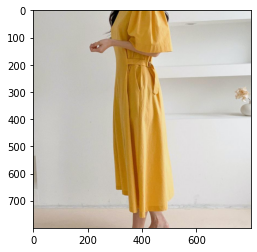

In [ ]:
#feminine, natural
filename = "/content/220731.jpg"

img = Image.open(filename).convert('RGB')

plt.imshow(img)

if val_transform is not None:
    
    img = val_transform(img)

wordvec = "/content/drive/MyDrive/kfashion_model/custom_glove_word2vec_final.pkl"

with open(wordvec, 'rb') as f:
    inp = pickle.load(f)

img = img.unsqueeze(0)
inp = torch.tensor(inp).unsqueeze(0)

feature_var = torch.autograd.Variable(img).float()
inp_var = torch.autograd.Variable(inp).float().detach()  # one hot

model.eval()

output = model(feature_var, inp_var)
percentage_output = F.softmax(output, dim = 1)


pred = output.cpu().detach().numpy()

sorted_pred = np.argsort(pred,axis = 1)

for i in range(9,-1,-1):
    
    print(f"top {10-i}: {change_category[sorted_pred[0][i]]}, conf:{percentage_output[0][sorted_pred[0][i]]*100:.4f}")

# inference data

In [ ]:
feature_var = torch.autograd.Variable(img).float()
inp_var = torch.autograd.Variable(inp).float().detach()  # one hot

model.eval()

output = model(feature_var, inp_var)


In [ ]:
output

tensor([[ -9.6854,  -0.7061,  -2.5424,  -9.1944,  -5.8106,  -6.4912,  -8.7202,
         -10.3212,  -1.9081,   8.0200]], grad_fn=<MmBackward0>)

In [ ]:
percentage_output = F.softmax(output, dim = 1)

In [ ]:
percentage_output

tensor([[2.0442e-08, 1.6226e-04, 2.5865e-05, 3.3402e-08, 9.8480e-07, 4.9859e-07,
         5.3671e-08, 1.0825e-08, 4.8775e-05, 9.9976e-01]],
       grad_fn=<SoftmaxBackward0>)

In [ ]:
output

tensor([[ -9.6854,  -0.7061,  -2.5424,  -9.1944,  -5.8106,  -6.4912,  -8.7202,
         -10.3212,  -1.9081,   8.0200]], grad_fn=<MmBackward0>)

In [ ]:
np.argsort(output.cpu().detach().numpy(),axis = 1)

array([[2, 3, 8, 4, 0, 1, 7, 6, 5, 9]])

In [ ]:
np.argsort(percentage_output.cpu().detach().numpy(),axis = 1)

array([[2, 3, 8, 4, 0, 1, 7, 6, 5, 9]])

In [ ]:
output[0][9]

tensor(3.0438, grad_fn=<SelectBackward0>)

In [ ]:
output[0][5]

tensor(-0.3158, grad_fn=<SelectBackward0>)

In [ ]:
output[0][6]

tensor(-2.0792, grad_fn=<SelectBackward0>)

In [ ]:
pred = output.cpu().detach().numpy()

sorted_pred = np.argsort(pred,axis = 1)

In [ ]:
for i in range(9,-1,-1):
    
    print(f"top {10-i}: {change_category[sorted_pred[0][i]]}, \n conf:{percentage_output[0][sorted_pred[0][i]]*100:.8f}")

top 1: casual, 
 conf:99.97616577
top 2: manish, 
 conf:0.01622591
top 3: subculture, 
 conf:0.00487747
top 4: feminine, 
 conf:0.00258650
top 5: contemporary, 
 conf:0.00009848
top 6: natural, 
 conf:0.00004986
top 7: genderless, 
 conf:0.00000537
top 8: ethnic, 
 conf:0.00000334
top 9: traditional, 
 conf:0.00000204
top 10: sporty, 
 conf:0.00000108


In [ ]:
#98463 answer: feminine, traditional
for i in range(9,-1,-1):
    
    print(f"top {10-i}: {change_category[sorted_pred[0][i]]}, conf:{percentage_output[0][i]*100:.8f}")

top 1: feminine, conf:0.00000524
top 2: traditional, conf:0.00007332
top 3: contemporary, conf:0.00000000
top 4: subculture, conf:0.00000000
top 5: casual, conf:0.00000000
top 6: manish, conf:0.00009145
top 7: ethnic, conf:0.00000032
top 8: natural, conf:98.11611938
top 9: genderless, conf:0.00000192
top 10: sporty, conf:1.88370883


In [ ]:
#185204 answer: natural, genderless

for i in range(9,6,-1):
    
    print(f"top {10-i}: {change_category[sorted_pred[0][i]]}, conf:{percentage_output[0][i]*100:.8f}")

top 1: casual, conf:98.34577942
top 2: manish, conf:0.17531787
top 3: genderless, conf:0.33098057


In [ ]:
class load_data(Data.Dataset):
    def __init__(self, root, phase='train', inp_name=None):
        self.root = root
        self.phase = phase
        self.img_list = []
        self.get_anno()
        self.num_classes = len(self.cat2idx)

        with open(inp_name, 'rb') as f:
            self.inp = pickle.load(f)

        self.inp_name = inp_name

    def get_anno(self):
        list_path = os.path.join(self.root, '{}_anno_custom_final_0.json'.format(self.phase))
        self.img_list = json.load(open(list_path, 'r'))
        self.cat2idx = json.load(open(os.path.join(self.root, 'category_custom_final.json'), 'r'))

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, index):
        item = self.img_list[index]
        return self.get(item)

    def get(self, item):
        filename = "/content/drive/MyDrive/kfashion" + item['file_name'][2:]
        labels = sorted(item['labels'])

        img = Image.open(filename).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
        target = np.zeros(self.num_classes, np.float32) - 1
        target[labels] = 1
        return (img, filename, self.inp), target

# test

In [ ]:
def on_end_epoch(p, r):
    
    pred = p.cpu().detach().numpy()
    real = r.cpu().detach().numpy()
    a, s_id, w_id, pp = top_n_recall(pred, real, 3)

    s = np.array(s_id)
    w = np.array(w_id)

    img_list = json.load(open('/content/drive/MyDrive/kfashion_model/test_anno_custom_final_0.json', 'r'))
    img_name_list = [x['file_name'] for x in img_list]

    l_r_s = real[s]
    l_p_s = pp[s]
    df = pd.DataFrame(np.array(img_name_list)[s])
    df['real'] = list(l_r_s)
    df['pred'] = list(l_p_s)
    df.columns = ['img', 'real', 'pred']
    df.to_csv('content/output/style_correct_3.csv')

    l_r_w = real[w]
    l_p_w = pp[w]
    df = pd.DataFrame(np.array(img_name_list)[w])
    df['real'] = list(l_r_w)
    df['pred'] = list(l_p_w)
    df.columns = ['img', 'real', 'pred']
    df.to_csv('content/output/style_wrong_3.csv')

    b, s_id, w_id, pp = top_n_recall(pred, real, 5)

    s = np.array(s_id)
    w = np.array(w_id)

    l_r_s = real[s]
    l_p_s = pp[s]
    df = pd.DataFrame(np.array(img_name_list)[s])
    df['real'] = list(l_r_s)
    df['pred'] = list(l_p_s)
    df.columns = ['img', 'real', 'pred']
    df.to_csv('content/output/style_correct_5.csv')

    l_r_w = real[w]
    l_p_w = pp[w]
    df = pd.DataFrame(np.array(img_name_list)[w])
    df['real'] = list(l_r_w)
    df['pred'] = list(l_p_w)
    df.columns = ['img', 'real', 'pred']
    df.to_csv('content/output/style_wrong_5.csv')

    return round(a, 4), round(b, 4)

In [ ]:
# define train and val transform
test_dataset.transform = val_transform
#test_dataset.target_transform = val_target_transform

# data loading code
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size, shuffle=False,
                                          num_workers=workers)

# optionally resume from a checkpoint
if resume is not None:
    if os.path.isfile(resume):
        print("=> loading checkpoint '{}'".format(resume))
        checkpoint = torch.load(resume, map_location=torch.device('cpu'))
        
        start_epoch = checkpoint['epoch']
        
        best_score = checkpoint['best_score']
        
        model.load_state_dict(checkpoint['state_dict'])

    else:
        print("=> no checkpoint found at '{}'".format(resume))


if use_gpu:
    test_loader.pin_memory = True
    cudnn.benchmark = True

    model = torch.nn.DataParallel(model, device_ids=device_ids).cuda()
    criterion = criterion.cuda()

model.eval()

if use_pb:
        
    data_loader = tqdm(test_loader, desc='Test')

    for i, (input, target) in enumerate(data_loader):
        # measure data loading time
        target_gt = target.clone()

        target[target == 0] = 1
        target[target == -1] = 0

        feature =  input[0]
        out =  input[1]
        input = input[2]

        if use_gpu:
            
            target = target.cuda()
        
        feature_var = torch.autograd.Variable(feature).float()
        target_var = torch.autograd.Variable(target).float()
        inp_var = torch.autograd.Variable(input).float().detach()  # one hot

        with torch.no_grad():
            # compute output
            output = model(feature_var, inp_var)
            loss = criterion(output, target_var)
        
        print(loss)
    
    a, b = on_end_epoch(output, target)
    
    print('Top-3 recall:', a)
    print('Top-5 recall:', b)

=> loading checkpoint '/content/drive/MyDrive/kfashion_model/checkpoint/model_best.pth.tar'


Test:   0%|          | 1/644 [03:10<34:03:38, 190.70s/it]

tensor(0.1968, device='cuda:0')


Test:   0%|          | 2/644 [03:11<14:02:06, 78.70s/it] 

tensor(0.1905, device='cuda:0')


Test:   0%|          | 3/644 [03:11<7:38:29, 42.92s/it] 

tensor(0.1975, device='cuda:0')


Test:   1%|          | 4/644 [03:11<4:38:23, 26.10s/it]

tensor(0.1272, device='cuda:0')


Test:   1%|          | 5/644 [03:11<2:58:56, 16.80s/it]

tensor(0.1720, device='cuda:0')


Test:   1%|          | 6/644 [03:12<1:59:02, 11.20s/it]

tensor(0.1654, device='cuda:0')


Test:   1%|          | 7/644 [03:12<1:21:05,  7.64s/it]

tensor(0.1765, device='cuda:0')


Test:   1%|          | 8/644 [03:12<56:14,  5.31s/it]  

tensor(0.2394, device='cuda:0')


Test:   1%|▏         | 9/644 [03:13<39:36,  3.74s/it]

tensor(0.2188, device='cuda:0')


Test:   2%|▏         | 10/644 [03:13<28:21,  2.68s/it]

tensor(0.1823, device='cuda:0')


Test:   2%|▏         | 11/644 [03:13<20:38,  1.96s/it]

tensor(0.1707, device='cuda:0')


Test:   2%|▏         | 12/644 [03:14<15:19,  1.46s/it]

tensor(0.3192, device='cuda:0')


Test:   2%|▏         | 13/644 [03:14<11:39,  1.11s/it]

tensor(0.2090, device='cuda:0')


Test:   2%|▏         | 14/644 [03:14<09:06,  1.15it/s]

tensor(0.1856, device='cuda:0')


Test:   2%|▏         | 15/644 [03:15<07:19,  1.43it/s]

tensor(0.1436, device='cuda:0')


Test:   2%|▏         | 16/644 [03:15<06:04,  1.72it/s]

tensor(0.2233, device='cuda:0')


Test:   3%|▎         | 17/644 [03:15<05:12,  2.00it/s]

tensor(0.2108, device='cuda:0')


Test:   3%|▎         | 18/644 [03:15<04:36,  2.26it/s]

tensor(0.1792, device='cuda:0')


Test:   3%|▎         | 19/644 [03:16<04:10,  2.50it/s]

tensor(0.2558, device='cuda:0')


Test:   3%|▎         | 20/644 [03:16<03:51,  2.69it/s]

tensor(0.2913, device='cuda:0')


Test:   3%|▎         | 21/644 [03:16<03:39,  2.84it/s]

tensor(0.1378, device='cuda:0')


Test:   3%|▎         | 22/644 [03:17<03:30,  2.95it/s]

tensor(0.2184, device='cuda:0')


Test:   4%|▎         | 23/644 [03:17<03:22,  3.06it/s]

tensor(0.1455, device='cuda:0')


Test:   4%|▎         | 24/644 [03:17<03:18,  3.12it/s]

tensor(0.2302, device='cuda:0')


Test:   4%|▍         | 25/644 [03:18<03:17,  3.14it/s]

tensor(0.1706, device='cuda:0')


Test:   4%|▍         | 26/644 [04:17<3:04:34, 17.92s/it]

tensor(0.1567, device='cuda:0')


Test:   4%|▍         | 27/644 [04:20<2:18:02, 13.42s/it]

tensor(0.2571, device='cuda:0')


Test:   4%|▍         | 28/644 [04:23<1:46:04, 10.33s/it]

tensor(0.1762, device='cuda:0')


Test:   5%|▍         | 29/644 [04:23<1:15:07,  7.33s/it]

tensor(0.1779, device='cuda:0')


Test:   5%|▍         | 30/644 [04:23<53:29,  5.23s/it]  

tensor(0.2107, device='cuda:0')


Test:   5%|▍         | 31/644 [04:24<38:25,  3.76s/it]

tensor(0.1687, device='cuda:0')


Test:   5%|▍         | 32/644 [04:26<32:55,  3.23s/it]

tensor(0.1572, device='cuda:0')


Test:   5%|▌         | 33/644 [04:26<23:56,  2.35s/it]

tensor(0.1796, device='cuda:0')


Test:   5%|▌         | 34/644 [04:26<17:44,  1.75s/it]

tensor(0.2161, device='cuda:0')


Test:   5%|▌         | 35/644 [04:27<13:21,  1.32s/it]

tensor(0.1645, device='cuda:0')


Test:   6%|▌         | 36/644 [04:27<10:15,  1.01s/it]

tensor(0.2053, device='cuda:0')


Test:   6%|▌         | 37/644 [04:27<08:07,  1.24it/s]

tensor(0.2561, device='cuda:0')


Test:   6%|▌         | 38/644 [04:28<06:39,  1.52it/s]

tensor(0.2434, device='cuda:0')


Test:   6%|▌         | 39/644 [04:28<05:35,  1.80it/s]

tensor(0.2260, device='cuda:0')


Test:   6%|▌         | 40/644 [04:28<04:55,  2.04it/s]

tensor(0.1480, device='cuda:0')


Test:   6%|▋         | 41/644 [04:29<04:24,  2.28it/s]

tensor(0.1694, device='cuda:0')


Test:   7%|▋         | 42/644 [04:29<03:59,  2.51it/s]

tensor(0.2279, device='cuda:0')


Test:   7%|▋         | 43/644 [04:29<03:45,  2.67it/s]

tensor(0.2656, device='cuda:0')


Test:   7%|▋         | 44/644 [04:29<03:37,  2.76it/s]

tensor(0.1600, device='cuda:0')


Test:   7%|▋         | 45/644 [04:30<03:28,  2.88it/s]

tensor(0.1876, device='cuda:0')


Test:   7%|▋         | 46/644 [04:30<03:23,  2.94it/s]

tensor(0.2755, device='cuda:0')


Test:   7%|▋         | 47/644 [04:30<03:18,  3.00it/s]

tensor(0.2670, device='cuda:0')


Test:   7%|▋         | 48/644 [04:31<03:15,  3.06it/s]

tensor(0.2102, device='cuda:0')


Test:   8%|▊         | 49/644 [04:31<03:12,  3.08it/s]

tensor(0.1719, device='cuda:0')


Test:   8%|▊         | 50/644 [04:31<03:10,  3.11it/s]

tensor(0.1357, device='cuda:0')


Test:   8%|▊         | 51/644 [05:35<3:10:43, 19.30s/it]

tensor(0.1667, device='cuda:0')


Test:   8%|▊         | 52/644 [05:40<2:28:36, 15.06s/it]

tensor(0.1668, device='cuda:0')


Test:   8%|▊         | 53/644 [05:40<1:44:44, 10.63s/it]

tensor(0.3035, device='cuda:0')


Test:   8%|▊         | 54/644 [05:41<1:14:05,  7.54s/it]

tensor(0.1483, device='cuda:0')


Test:   9%|▊         | 55/644 [05:41<52:45,  5.37s/it]  

tensor(0.2212, device='cuda:0')


Test:   9%|▊         | 56/644 [05:41<37:48,  3.86s/it]

tensor(0.1536, device='cuda:0')


Test:   9%|▉         | 57/644 [05:44<33:34,  3.43s/it]

tensor(0.1631, device='cuda:0')


Test:   9%|▉         | 58/644 [05:44<24:23,  2.50s/it]

tensor(0.1871, device='cuda:0')


Test:   9%|▉         | 59/644 [05:44<17:56,  1.84s/it]

tensor(0.2584, device='cuda:0')


Test:   9%|▉         | 60/644 [05:45<13:29,  1.39s/it]

tensor(0.1491, device='cuda:0')


Test:   9%|▉         | 61/644 [05:45<10:20,  1.07s/it]

tensor(0.1619, device='cuda:0')


Test:  10%|▉         | 62/644 [05:45<08:07,  1.19it/s]

tensor(0.3206, device='cuda:0')


Test:  10%|▉         | 63/644 [05:46<06:37,  1.46it/s]

tensor(0.1994, device='cuda:0')


Test:  10%|▉         | 64/644 [05:46<05:32,  1.74it/s]

tensor(0.1316, device='cuda:0')


Test:  10%|█         | 65/644 [05:46<04:47,  2.01it/s]

tensor(0.1764, device='cuda:0')


Test:  10%|█         | 66/644 [05:47<04:16,  2.26it/s]

tensor(0.1619, device='cuda:0')


Test:  10%|█         | 67/644 [05:47<03:54,  2.46it/s]

tensor(0.1729, device='cuda:0')


Test:  11%|█         | 68/644 [05:47<03:37,  2.65it/s]

tensor(0.2096, device='cuda:0')


Test:  11%|█         | 69/644 [05:48<03:26,  2.78it/s]

tensor(0.1712, device='cuda:0')


Test:  11%|█         | 70/644 [05:48<03:19,  2.88it/s]

tensor(0.1310, device='cuda:0')


Test:  11%|█         | 71/644 [05:48<03:13,  2.96it/s]

tensor(0.1552, device='cuda:0')


Test:  11%|█         | 72/644 [05:49<03:10,  3.01it/s]

tensor(0.1855, device='cuda:0')


Test:  11%|█▏        | 73/644 [05:49<03:07,  3.05it/s]

tensor(0.1332, device='cuda:0')


Test:  11%|█▏        | 74/644 [05:49<03:05,  3.07it/s]

tensor(0.1465, device='cuda:0')


Test:  12%|█▏        | 75/644 [05:50<03:07,  3.03it/s]

tensor(0.1708, device='cuda:0')


Test:  12%|█▏        | 76/644 [06:56<3:10:18, 20.10s/it]

tensor(0.2260, device='cuda:0')


Test:  12%|█▏        | 77/644 [06:57<2:15:46, 14.37s/it]

tensor(0.2106, device='cuda:0')


Test:  12%|█▏        | 78/644 [06:58<1:37:13, 10.31s/it]

tensor(0.1767, device='cuda:0')


Test:  12%|█▏        | 79/644 [06:58<1:08:48,  7.31s/it]

tensor(0.2541, device='cuda:0')


Test:  12%|█▏        | 80/644 [06:58<49:02,  5.22s/it]  

tensor(0.2156, device='cuda:0')


Test:  13%|█▎        | 81/644 [06:59<35:09,  3.75s/it]

tensor(0.1229, device='cuda:0')


Test:  13%|█▎        | 82/644 [07:01<31:25,  3.36s/it]

tensor(0.2627, device='cuda:0')


Test:  13%|█▎        | 83/644 [07:01<22:50,  2.44s/it]

tensor(0.1618, device='cuda:0')


Test:  13%|█▎        | 84/644 [07:02<16:49,  1.80s/it]

tensor(0.1919, device='cuda:0')


Test:  13%|█▎        | 85/644 [07:02<12:42,  1.36s/it]

tensor(0.2178, device='cuda:0')


Test:  13%|█▎        | 86/644 [07:02<09:45,  1.05s/it]

tensor(0.1767, device='cuda:0')


Test:  14%|█▎        | 87/644 [07:03<07:40,  1.21it/s]

tensor(0.2038, device='cuda:0')


Test:  14%|█▎        | 88/644 [07:03<06:17,  1.47it/s]

tensor(0.1708, device='cuda:0')


Test:  14%|█▍        | 89/644 [07:03<05:17,  1.75it/s]

tensor(0.1989, device='cuda:0')


Test:  14%|█▍        | 90/644 [07:04<04:33,  2.02it/s]

tensor(0.1521, device='cuda:0')


Test:  14%|█▍        | 91/644 [07:04<04:05,  2.25it/s]

tensor(0.2376, device='cuda:0')


Test:  14%|█▍        | 92/644 [07:04<03:45,  2.45it/s]

tensor(0.1630, device='cuda:0')


Test:  14%|█▍        | 93/644 [07:05<03:31,  2.61it/s]

tensor(0.1956, device='cuda:0')


Test:  15%|█▍        | 94/644 [07:05<03:21,  2.73it/s]

tensor(0.1573, device='cuda:0')


Test:  15%|█▍        | 95/644 [07:05<03:16,  2.79it/s]

tensor(0.2548, device='cuda:0')


Test:  15%|█▍        | 96/644 [07:06<03:10,  2.88it/s]

tensor(0.1841, device='cuda:0')


Test:  15%|█▌        | 97/644 [07:06<03:16,  2.78it/s]

tensor(0.1893, device='cuda:0')


Test:  15%|█▌        | 98/644 [07:06<03:09,  2.88it/s]

tensor(0.1425, device='cuda:0')


Test:  15%|█▌        | 99/644 [07:07<03:11,  2.84it/s]

tensor(0.1370, device='cuda:0')


Test:  16%|█▌        | 100/644 [07:07<03:06,  2.92it/s]

tensor(0.1586, device='cuda:0')


Test:  16%|█▌        | 101/644 [08:17<3:13:27, 21.38s/it]

tensor(0.1873, device='cuda:0')


Test:  16%|█▌        | 102/644 [08:22<2:26:22, 16.20s/it]

tensor(0.2284, device='cuda:0')


Test:  16%|█▌        | 103/644 [08:22<1:43:12, 11.45s/it]

tensor(0.1939, device='cuda:0')


Test:  16%|█▌        | 104/644 [08:22<1:12:57,  8.11s/it]

tensor(0.2463, device='cuda:0')


Test:  16%|█▋        | 105/644 [08:23<51:56,  5.78s/it]  

tensor(0.2164, device='cuda:0')


Test:  16%|█▋        | 106/644 [08:23<37:09,  4.14s/it]

tensor(0.1805, device='cuda:0')


Test:  17%|█▋        | 107/644 [08:23<26:49,  3.00s/it]

tensor(0.1317, device='cuda:0')


Test:  17%|█▋        | 108/644 [08:24<19:40,  2.20s/it]

tensor(0.1563, device='cuda:0')


Test:  17%|█▋        | 109/644 [08:24<14:37,  1.64s/it]

tensor(0.1246, device='cuda:0')


Test:  17%|█▋        | 110/644 [08:24<11:04,  1.24s/it]

tensor(0.1317, device='cuda:0')


Test:  17%|█▋        | 111/644 [08:24<08:37,  1.03it/s]

tensor(0.1892, device='cuda:0')


Test:  17%|█▋        | 112/644 [08:25<06:55,  1.28it/s]

tensor(0.1532, device='cuda:0')


Test:  18%|█▊        | 113/644 [08:25<05:41,  1.56it/s]

tensor(0.1804, device='cuda:0')


Test:  18%|█▊        | 114/644 [08:25<04:53,  1.81it/s]

tensor(0.1808, device='cuda:0')


Test:  18%|█▊        | 115/644 [08:26<04:16,  2.06it/s]

tensor(0.1546, device='cuda:0')


Test:  18%|█▊        | 116/644 [08:26<03:50,  2.29it/s]

tensor(0.2037, device='cuda:0')


Test:  18%|█▊        | 117/644 [08:26<03:32,  2.48it/s]

tensor(0.2165, device='cuda:0')


Test:  18%|█▊        | 118/644 [08:27<03:21,  2.61it/s]

tensor(0.2106, device='cuda:0')


Test:  18%|█▊        | 119/644 [08:27<03:13,  2.71it/s]

tensor(0.2450, device='cuda:0')


Test:  19%|█▊        | 120/644 [08:27<03:08,  2.79it/s]

tensor(0.2300, device='cuda:0')


Test:  19%|█▉        | 121/644 [08:28<03:01,  2.88it/s]

tensor(0.1174, device='cuda:0')


Test:  19%|█▉        | 122/644 [08:28<02:58,  2.93it/s]

tensor(0.1873, device='cuda:0')


Test:  19%|█▉        | 123/644 [08:28<02:56,  2.95it/s]

tensor(0.1764, device='cuda:0')


Test:  19%|█▉        | 124/644 [08:29<02:53,  3.00it/s]

tensor(0.2038, device='cuda:0')


Test:  19%|█▉        | 125/644 [08:29<02:52,  3.02it/s]

tensor(0.1260, device='cuda:0')


Test:  20%|█▉        | 126/644 [09:32<2:43:41, 18.96s/it]

tensor(0.1894, device='cuda:0')


Test:  20%|█▉        | 127/644 [09:37<2:09:44, 15.06s/it]

tensor(0.1521, device='cuda:0')


Test:  20%|█▉        | 128/644 [09:38<1:31:26, 10.63s/it]

tensor(0.1604, device='cuda:0')


Test:  20%|██        | 129/644 [09:38<1:04:42,  7.54s/it]

tensor(0.1700, device='cuda:0')


Test:  20%|██        | 130/644 [09:38<46:05,  5.38s/it]  

tensor(0.1954, device='cuda:0')


Test:  20%|██        | 131/644 [09:39<33:02,  3.86s/it]

tensor(0.1805, device='cuda:0')


Test:  20%|██        | 132/644 [09:39<23:53,  2.80s/it]

tensor(0.1441, device='cuda:0')


Test:  21%|██        | 133/644 [09:39<17:34,  2.06s/it]

tensor(0.1757, device='cuda:0')


Test:  21%|██        | 134/644 [09:40<13:05,  1.54s/it]

tensor(0.3103, device='cuda:0')


Test:  21%|██        | 135/644 [09:40<09:58,  1.17s/it]

tensor(0.3154, device='cuda:0')


Test:  21%|██        | 136/644 [09:40<07:49,  1.08it/s]

tensor(0.1719, device='cuda:0')


Test:  21%|██▏       | 137/644 [09:41<06:17,  1.34it/s]

tensor(0.1404, device='cuda:0')


Test:  21%|██▏       | 138/644 [09:41<05:13,  1.62it/s]

tensor(0.1911, device='cuda:0')


Test:  22%|██▏       | 139/644 [09:41<04:29,  1.87it/s]

tensor(0.1671, device='cuda:0')


Test:  22%|██▏       | 140/644 [09:42<03:58,  2.12it/s]

tensor(0.1917, device='cuda:0')


Test:  22%|██▏       | 141/644 [09:42<03:36,  2.33it/s]

tensor(0.1822, device='cuda:0')


Test:  22%|██▏       | 142/644 [09:42<03:21,  2.49it/s]

tensor(0.2929, device='cuda:0')


Test:  22%|██▏       | 143/644 [09:43<03:12,  2.61it/s]

tensor(0.1245, device='cuda:0')


Test:  22%|██▏       | 144/644 [09:43<03:03,  2.73it/s]

tensor(0.2035, device='cuda:0')


Test:  23%|██▎       | 145/644 [09:43<02:57,  2.81it/s]

tensor(0.1662, device='cuda:0')


Test:  23%|██▎       | 146/644 [09:44<02:54,  2.86it/s]

tensor(0.1703, device='cuda:0')


Test:  23%|██▎       | 147/644 [09:44<02:50,  2.91it/s]

tensor(0.2643, device='cuda:0')


Test:  23%|██▎       | 148/644 [09:44<02:49,  2.93it/s]

tensor(0.1491, device='cuda:0')


Test:  23%|██▎       | 149/644 [09:45<02:47,  2.95it/s]

tensor(0.2384, device='cuda:0')


Test:  23%|██▎       | 150/644 [09:45<02:46,  2.96it/s]

tensor(0.1376, device='cuda:0')


Test:  23%|██▎       | 151/644 [10:46<2:31:38, 18.46s/it]

tensor(0.1930, device='cuda:0')


Test:  24%|██▎       | 152/644 [10:51<1:59:42, 14.60s/it]

tensor(0.1778, device='cuda:0')


Test:  24%|██▍       | 153/644 [10:52<1:24:25, 10.32s/it]

tensor(0.1704, device='cuda:0')


Test:  24%|██▍       | 154/644 [10:52<59:45,  7.32s/it]  

tensor(0.2231, device='cuda:0')


Test:  24%|██▍       | 155/644 [10:52<42:35,  5.23s/it]

tensor(0.1745, device='cuda:0')


Test:  24%|██▍       | 156/644 [10:53<30:31,  3.75s/it]

tensor(0.2795, device='cuda:0')


Test:  24%|██▍       | 157/644 [10:53<22:06,  2.72s/it]

tensor(0.2447, device='cuda:0')


Test:  25%|██▍       | 158/644 [10:53<16:16,  2.01s/it]

tensor(0.2532, device='cuda:0')


Test:  25%|██▍       | 159/644 [10:54<12:09,  1.51s/it]

tensor(0.1594, device='cuda:0')


Test:  25%|██▍       | 160/644 [10:54<09:17,  1.15s/it]

tensor(0.1429, device='cuda:0')


Test:  25%|██▌       | 161/644 [10:54<07:18,  1.10it/s]

tensor(0.1798, device='cuda:0')


Test:  25%|██▌       | 162/644 [10:55<05:54,  1.36it/s]

tensor(0.1383, device='cuda:0')


Test:  25%|██▌       | 163/644 [10:55<04:54,  1.63it/s]

tensor(0.1617, device='cuda:0')


Test:  25%|██▌       | 164/644 [10:55<04:14,  1.89it/s]

tensor(0.1520, device='cuda:0')


Test:  26%|██▌       | 165/644 [10:56<03:47,  2.11it/s]

tensor(0.1936, device='cuda:0')


Test:  26%|██▌       | 166/644 [10:56<03:26,  2.31it/s]

tensor(0.1327, device='cuda:0')


Test:  26%|██▌       | 167/644 [10:56<03:13,  2.47it/s]

tensor(0.2135, device='cuda:0')


Test:  26%|██▌       | 168/644 [10:57<03:03,  2.60it/s]

tensor(0.1312, device='cuda:0')


Test:  26%|██▌       | 169/644 [10:57<02:55,  2.71it/s]

tensor(0.1804, device='cuda:0')


Test:  26%|██▋       | 170/644 [10:57<02:51,  2.77it/s]

tensor(0.2315, device='cuda:0')


Test:  27%|██▋       | 171/644 [10:58<02:46,  2.84it/s]

tensor(0.2794, device='cuda:0')


Test:  27%|██▋       | 172/644 [10:58<02:43,  2.89it/s]

tensor(0.3535, device='cuda:0')


Test:  27%|██▋       | 173/644 [10:58<02:42,  2.90it/s]

tensor(0.1321, device='cuda:0')


Test:  27%|██▋       | 174/644 [10:59<02:40,  2.93it/s]

tensor(0.1396, device='cuda:0')


Test:  27%|██▋       | 175/644 [10:59<02:38,  2.96it/s]

tensor(0.2040, device='cuda:0')


Test:  27%|██▋       | 176/644 [12:00<2:23:36, 18.41s/it]

tensor(0.1546, device='cuda:0')


Test:  27%|██▋       | 177/644 [12:07<1:57:00, 15.03s/it]

tensor(0.1735, device='cuda:0')


Test:  28%|██▊       | 178/644 [12:07<1:22:28, 10.62s/it]

tensor(0.1491, device='cuda:0')


Test:  28%|██▊       | 179/644 [12:07<58:19,  7.53s/it]  

tensor(0.1766, device='cuda:0')


Test:  28%|██▊       | 180/644 [12:08<41:34,  5.38s/it]

tensor(0.1822, device='cuda:0')


Test:  28%|██▊       | 181/644 [12:08<29:47,  3.86s/it]

tensor(0.1955, device='cuda:0')


Test:  28%|██▊       | 182/644 [12:08<21:32,  2.80s/it]

tensor(0.1926, device='cuda:0')


Test:  28%|██▊       | 183/644 [12:09<15:50,  2.06s/it]

tensor(0.1962, device='cuda:0')


Test:  29%|██▊       | 184/644 [12:09<11:48,  1.54s/it]

tensor(0.1613, device='cuda:0')


Test:  29%|██▊       | 185/644 [12:09<08:59,  1.18s/it]

tensor(0.1702, device='cuda:0')


Test:  29%|██▉       | 186/644 [12:10<07:03,  1.08it/s]

tensor(0.1549, device='cuda:0')


Test:  29%|██▉       | 187/644 [12:10<05:41,  1.34it/s]

tensor(0.1589, device='cuda:0')


Test:  29%|██▉       | 188/644 [12:10<04:44,  1.61it/s]

tensor(0.2405, device='cuda:0')


Test:  29%|██▉       | 189/644 [12:11<04:04,  1.86it/s]

tensor(0.1652, device='cuda:0')


Test:  30%|██▉       | 190/644 [12:11<03:36,  2.09it/s]

tensor(0.2175, device='cuda:0')


Test:  30%|██▉       | 191/644 [12:11<03:15,  2.32it/s]

tensor(0.1674, device='cuda:0')


Test:  30%|██▉       | 192/644 [12:12<03:01,  2.48it/s]

tensor(0.3150, device='cuda:0')


Test:  30%|██▉       | 193/644 [12:12<02:52,  2.62it/s]

tensor(0.2577, device='cuda:0')


Test:  30%|███       | 194/644 [12:12<02:44,  2.74it/s]

tensor(0.1804, device='cuda:0')


Test:  30%|███       | 195/644 [12:13<02:40,  2.80it/s]

tensor(0.1360, device='cuda:0')


Test:  30%|███       | 196/644 [12:13<02:36,  2.86it/s]

tensor(0.2353, device='cuda:0')


Test:  31%|███       | 197/644 [12:13<02:34,  2.89it/s]

tensor(0.2352, device='cuda:0')


Test:  31%|███       | 198/644 [12:14<02:32,  2.93it/s]

tensor(0.2342, device='cuda:0')


Test:  31%|███       | 199/644 [12:14<02:30,  2.95it/s]

tensor(0.2397, device='cuda:0')


Test:  31%|███       | 200/644 [12:14<02:30,  2.96it/s]

tensor(0.2285, device='cuda:0')


Test:  31%|███       | 201/644 [13:14<2:13:26, 18.07s/it]

tensor(0.1376, device='cuda:0')


Test:  31%|███▏      | 202/644 [13:20<1:46:15, 14.42s/it]

tensor(0.1720, device='cuda:0')


Test:  32%|███▏      | 203/644 [13:20<1:14:54, 10.19s/it]

tensor(0.1481, device='cuda:0')


Test:  32%|███▏      | 204/644 [13:20<53:02,  7.23s/it]  

tensor(0.1959, device='cuda:0')


Test:  32%|███▏      | 205/644 [13:21<37:47,  5.17s/it]

tensor(0.2475, device='cuda:0')


Test:  32%|███▏      | 206/644 [13:21<27:05,  3.71s/it]

tensor(0.2121, device='cuda:0')


Test:  32%|███▏      | 207/644 [13:21<19:39,  2.70s/it]

tensor(0.2083, device='cuda:0')


Test:  32%|███▏      | 208/644 [13:22<14:27,  1.99s/it]

tensor(0.1978, device='cuda:0')


Test:  32%|███▏      | 209/644 [13:22<10:49,  1.49s/it]

tensor(0.1603, device='cuda:0')


Test:  33%|███▎      | 210/644 [13:22<08:15,  1.14s/it]

tensor(0.2286, device='cuda:0')


Test:  33%|███▎      | 211/644 [13:23<06:29,  1.11it/s]

tensor(0.1485, device='cuda:0')


Test:  33%|███▎      | 212/644 [13:23<05:15,  1.37it/s]

tensor(0.3048, device='cuda:0')


Test:  33%|███▎      | 213/644 [13:23<04:23,  1.64it/s]

tensor(0.1607, device='cuda:0')


Test:  33%|███▎      | 214/644 [13:24<03:47,  1.89it/s]

tensor(0.1845, device='cuda:0')


Test:  33%|███▎      | 215/644 [13:24<03:21,  2.13it/s]

tensor(0.2094, device='cuda:0')


Test:  34%|███▎      | 216/644 [13:24<03:04,  2.32it/s]

tensor(0.2384, device='cuda:0')


Test:  34%|███▎      | 217/644 [13:25<02:50,  2.50it/s]

tensor(0.2100, device='cuda:0')


Test:  34%|███▍      | 218/644 [13:25<02:42,  2.63it/s]

tensor(0.2300, device='cuda:0')


Test:  34%|███▍      | 219/644 [13:25<02:36,  2.72it/s]

tensor(0.2275, device='cuda:0')


Test:  34%|███▍      | 220/644 [13:26<02:31,  2.79it/s]

tensor(0.2850, device='cuda:0')


Test:  34%|███▍      | 221/644 [13:26<02:28,  2.85it/s]

tensor(0.1890, device='cuda:0')


Test:  34%|███▍      | 222/644 [13:26<02:26,  2.88it/s]

tensor(0.2449, device='cuda:0')


Test:  35%|███▍      | 223/644 [13:27<02:24,  2.92it/s]

tensor(0.2163, device='cuda:0')


Test:  35%|███▍      | 224/644 [13:27<02:24,  2.91it/s]

tensor(0.2762, device='cuda:0')


Test:  35%|███▍      | 225/644 [13:27<02:24,  2.90it/s]

tensor(0.3401, device='cuda:0')


Test:  35%|███▌      | 226/644 [14:28<2:07:52, 18.35s/it]

tensor(0.1356, device='cuda:0')


Test:  35%|███▌      | 227/644 [14:34<1:41:19, 14.58s/it]

tensor(0.1694, device='cuda:0')


Test:  35%|███▌      | 228/644 [14:34<1:11:24, 10.30s/it]

tensor(0.1976, device='cuda:0')


Test:  36%|███▌      | 229/644 [14:34<50:31,  7.30s/it]  

tensor(0.3095, device='cuda:0')


Test:  36%|███▌      | 230/644 [14:35<35:59,  5.22s/it]

tensor(0.1864, device='cuda:0')


Test:  36%|███▌      | 231/644 [14:35<25:49,  3.75s/it]

tensor(0.1737, device='cuda:0')


Test:  36%|███▌      | 232/644 [14:35<18:41,  2.72s/it]

tensor(0.1630, device='cuda:0')


Test:  36%|███▌      | 233/644 [14:36<13:46,  2.01s/it]

tensor(0.1886, device='cuda:0')


Test:  36%|███▋      | 234/644 [14:36<10:17,  1.51s/it]

tensor(0.2304, device='cuda:0')


Test:  36%|███▋      | 235/644 [14:36<07:50,  1.15s/it]

tensor(0.1631, device='cuda:0')


Test:  37%|███▋      | 236/644 [14:37<06:10,  1.10it/s]

tensor(0.2854, device='cuda:0')


Test:  37%|███▋      | 237/644 [14:37<04:59,  1.36it/s]

tensor(0.1663, device='cuda:0')


Test:  37%|███▋      | 238/644 [14:37<04:08,  1.64it/s]

tensor(0.1822, device='cuda:0')


Test:  37%|███▋      | 239/644 [14:38<03:34,  1.88it/s]

tensor(0.1481, device='cuda:0')


Test:  37%|███▋      | 240/644 [14:38<03:11,  2.11it/s]

tensor(0.1361, device='cuda:0')


Test:  37%|███▋      | 241/644 [14:38<02:53,  2.32it/s]

tensor(0.1749, device='cuda:0')


Test:  38%|███▊      | 242/644 [14:39<02:42,  2.48it/s]

tensor(0.1595, device='cuda:0')


Test:  38%|███▊      | 243/644 [14:39<02:33,  2.61it/s]

tensor(0.1891, device='cuda:0')


Test:  38%|███▊      | 244/644 [14:39<02:25,  2.74it/s]

tensor(0.1597, device='cuda:0')


Test:  38%|███▊      | 245/644 [14:40<02:22,  2.80it/s]

tensor(0.1649, device='cuda:0')


Test:  38%|███▊      | 246/644 [14:40<02:19,  2.85it/s]

tensor(0.1917, device='cuda:0')


Test:  38%|███▊      | 247/644 [14:40<02:16,  2.90it/s]

tensor(0.2818, device='cuda:0')


Test:  39%|███▊      | 248/644 [14:41<02:15,  2.93it/s]

tensor(0.2264, device='cuda:0')


Test:  39%|███▊      | 249/644 [14:41<02:14,  2.94it/s]

tensor(0.2865, device='cuda:0')


Test:  39%|███▉      | 250/644 [14:41<02:16,  2.90it/s]

tensor(0.1921, device='cuda:0')


Test:  39%|███▉      | 251/644 [15:41<1:58:36, 18.11s/it]

tensor(0.2207, device='cuda:0')


Test:  39%|███▉      | 252/644 [15:47<1:35:24, 14.60s/it]

tensor(0.2052, device='cuda:0')


Test:  39%|███▉      | 253/644 [15:48<1:07:13, 10.32s/it]

tensor(0.1875, device='cuda:0')


Test:  39%|███▉      | 254/644 [15:48<47:34,  7.32s/it]  

tensor(0.1875, device='cuda:0')


Test:  40%|███▉      | 255/644 [15:48<33:53,  5.23s/it]

tensor(0.2041, device='cuda:0')


Test:  40%|███▉      | 256/644 [15:49<24:17,  3.76s/it]

tensor(0.2695, device='cuda:0')


Test:  40%|███▉      | 257/644 [15:49<17:35,  2.73s/it]

tensor(0.1970, device='cuda:0')


Test:  40%|████      | 258/644 [15:49<12:56,  2.01s/it]

tensor(0.1687, device='cuda:0')


Test:  40%|████      | 259/644 [15:50<09:40,  1.51s/it]

tensor(0.2067, device='cuda:0')


Test:  40%|████      | 260/644 [15:50<07:22,  1.15s/it]

tensor(0.1590, device='cuda:0')


Test:  41%|████      | 261/644 [15:50<05:47,  1.10it/s]

tensor(0.2604, device='cuda:0')


Test:  41%|████      | 262/644 [15:51<04:40,  1.36it/s]

tensor(0.1983, device='cuda:0')


Test:  41%|████      | 263/644 [15:51<03:53,  1.63it/s]

tensor(0.3081, device='cuda:0')


Test:  41%|████      | 264/644 [15:51<03:20,  1.89it/s]

tensor(0.1170, device='cuda:0')


Test:  41%|████      | 265/644 [15:52<02:58,  2.13it/s]

tensor(0.2039, device='cuda:0')


Test:  41%|████▏     | 266/644 [15:52<02:41,  2.33it/s]

tensor(0.2037, device='cuda:0')


Test:  41%|████▏     | 267/644 [15:52<02:30,  2.50it/s]

tensor(0.1953, device='cuda:0')


Test:  42%|████▏     | 268/644 [15:53<02:22,  2.63it/s]

tensor(0.1657, device='cuda:0')


Test:  42%|████▏     | 269/644 [15:53<02:17,  2.73it/s]

tensor(0.2159, device='cuda:0')


Test:  42%|████▏     | 270/644 [15:53<02:13,  2.81it/s]

tensor(0.2185, device='cuda:0')


Test:  42%|████▏     | 271/644 [15:54<02:11,  2.85it/s]

tensor(0.2468, device='cuda:0')


Test:  42%|████▏     | 272/644 [15:54<02:08,  2.89it/s]

tensor(0.1718, device='cuda:0')


Test:  42%|████▏     | 273/644 [15:54<02:07,  2.91it/s]

tensor(0.1614, device='cuda:0')


Test:  43%|████▎     | 274/644 [15:55<02:07,  2.91it/s]

tensor(0.1526, device='cuda:0')


Test:  43%|████▎     | 275/644 [15:55<02:06,  2.93it/s]

tensor(0.2127, device='cuda:0')


Test:  43%|████▎     | 276/644 [16:53<1:48:57, 17.76s/it]

tensor(0.1841, device='cuda:0')


Test:  43%|████▎     | 277/644 [17:01<1:30:26, 14.79s/it]

tensor(0.1938, device='cuda:0')


Test:  43%|████▎     | 278/644 [17:02<1:03:46, 10.45s/it]

tensor(0.2024, device='cuda:0')


Test:  43%|████▎     | 279/644 [17:02<45:10,  7.43s/it]  

tensor(0.2840, device='cuda:0')


Test:  43%|████▎     | 280/644 [17:02<32:10,  5.30s/it]

tensor(0.1889, device='cuda:0')


Test:  44%|████▎     | 281/644 [17:03<23:04,  3.81s/it]

tensor(0.2351, device='cuda:0')


Test:  44%|████▍     | 282/644 [17:03<16:40,  2.76s/it]

tensor(0.1998, device='cuda:0')


Test:  44%|████▍     | 283/644 [17:03<12:15,  2.04s/it]

tensor(0.1857, device='cuda:0')


Test:  44%|████▍     | 284/644 [17:04<09:09,  1.53s/it]

tensor(0.1711, device='cuda:0')


Test:  44%|████▍     | 285/644 [17:04<06:58,  1.17s/it]

tensor(0.1747, device='cuda:0')


Test:  44%|████▍     | 286/644 [17:04<05:27,  1.09it/s]

tensor(0.3484, device='cuda:0')


Test:  45%|████▍     | 287/644 [17:05<04:25,  1.35it/s]

tensor(0.1320, device='cuda:0')


Test:  45%|████▍     | 288/644 [17:05<03:40,  1.61it/s]

tensor(0.1838, device='cuda:0')


Test:  45%|████▍     | 289/644 [17:05<03:09,  1.88it/s]

tensor(0.2077, device='cuda:0')


Test:  45%|████▌     | 290/644 [17:06<02:48,  2.10it/s]

tensor(0.1828, device='cuda:0')


Test:  45%|████▌     | 291/644 [17:06<02:32,  2.32it/s]

tensor(0.1835, device='cuda:0')


Test:  45%|████▌     | 292/644 [17:06<02:21,  2.49it/s]

tensor(0.3517, device='cuda:0')


Test:  45%|████▌     | 293/644 [17:07<02:14,  2.60it/s]

tensor(0.1489, device='cuda:0')


Test:  46%|████▌     | 294/644 [17:07<02:09,  2.71it/s]

tensor(0.1427, device='cuda:0')


Test:  46%|████▌     | 295/644 [17:07<02:04,  2.80it/s]

tensor(0.2100, device='cuda:0')


Test:  46%|████▌     | 296/644 [17:08<02:02,  2.84it/s]

tensor(0.1785, device='cuda:0')


Test:  46%|████▌     | 297/644 [17:08<02:02,  2.83it/s]

tensor(0.1753, device='cuda:0')


Test:  46%|████▋     | 298/644 [17:08<02:00,  2.88it/s]

tensor(0.1917, device='cuda:0')


Test:  46%|████▋     | 299/644 [17:09<01:59,  2.89it/s]

tensor(0.1593, device='cuda:0')


Test:  47%|████▋     | 300/644 [17:09<02:00,  2.87it/s]

tensor(0.1613, device='cuda:0')


Test:  47%|████▋     | 301/644 [18:06<1:40:03, 17.50s/it]

tensor(0.2102, device='cuda:0')


Test:  47%|████▋     | 302/644 [18:15<1:24:13, 14.78s/it]

tensor(0.2061, device='cuda:0')


Test:  47%|████▋     | 303/644 [18:15<59:19, 10.44s/it]  

tensor(0.1163, device='cuda:0')


Test:  47%|████▋     | 304/644 [18:16<41:56,  7.40s/it]

tensor(0.1866, device='cuda:0')


Test:  47%|████▋     | 305/644 [18:16<29:52,  5.29s/it]

tensor(0.1611, device='cuda:0')


Test:  48%|████▊     | 306/644 [18:16<21:23,  3.80s/it]

tensor(0.1313, device='cuda:0')


Test:  48%|████▊     | 307/644 [18:17<15:28,  2.75s/it]

tensor(0.1915, device='cuda:0')


Test:  48%|████▊     | 308/644 [18:17<11:21,  2.03s/it]

tensor(0.1913, device='cuda:0')


Test:  48%|████▊     | 309/644 [18:17<08:28,  1.52s/it]

tensor(0.1943, device='cuda:0')


Test:  48%|████▊     | 310/644 [18:18<06:28,  1.16s/it]

tensor(0.2341, device='cuda:0')


Test:  48%|████▊     | 311/644 [18:18<05:04,  1.09it/s]

tensor(0.2345, device='cuda:0')


Test:  48%|████▊     | 312/644 [18:18<04:05,  1.35it/s]

tensor(0.1939, device='cuda:0')


Test:  49%|████▊     | 313/644 [18:19<03:23,  1.62it/s]

tensor(0.2974, device='cuda:0')


Test:  49%|████▉     | 314/644 [18:19<02:54,  1.89it/s]

tensor(0.3343, device='cuda:0')


Test:  49%|████▉     | 315/644 [18:19<02:35,  2.12it/s]

tensor(0.1829, device='cuda:0')


Test:  49%|████▉     | 316/644 [18:20<02:20,  2.33it/s]

tensor(0.1940, device='cuda:0')


Test:  49%|████▉     | 317/644 [18:20<02:11,  2.49it/s]

tensor(0.2307, device='cuda:0')


Test:  49%|████▉     | 318/644 [18:20<02:04,  2.62it/s]

tensor(0.2505, device='cuda:0')


Test:  50%|████▉     | 319/644 [18:21<01:59,  2.72it/s]

tensor(0.2351, device='cuda:0')


Test:  50%|████▉     | 320/644 [18:21<01:55,  2.79it/s]

tensor(0.1870, device='cuda:0')


Test:  50%|████▉     | 321/644 [18:21<01:53,  2.85it/s]

tensor(0.1585, device='cuda:0')


Test:  50%|█████     | 322/644 [18:22<01:51,  2.88it/s]

tensor(0.1517, device='cuda:0')


Test:  50%|█████     | 323/644 [18:22<01:51,  2.89it/s]

tensor(0.1438, device='cuda:0')


Test:  50%|█████     | 324/644 [18:22<01:50,  2.90it/s]

tensor(0.1853, device='cuda:0')


Test:  50%|█████     | 325/644 [18:23<01:50,  2.88it/s]

tensor(0.2145, device='cuda:0')


Test:  51%|█████     | 326/644 [19:19<1:30:55, 17.16s/it]

tensor(0.1933, device='cuda:0')


Test:  51%|█████     | 327/644 [19:27<1:15:34, 14.30s/it]

tensor(0.1568, device='cuda:0')


Test:  51%|█████     | 328/644 [19:27<53:14, 10.11s/it]  

tensor(0.1850, device='cuda:0')


Test:  51%|█████     | 329/644 [19:27<37:39,  7.17s/it]

tensor(0.2248, device='cuda:0')


Test:  51%|█████     | 330/644 [19:28<26:48,  5.12s/it]

tensor(0.2027, device='cuda:0')


Test:  51%|█████▏    | 331/644 [19:28<19:12,  3.68s/it]

tensor(0.1604, device='cuda:0')


Test:  52%|█████▏    | 332/644 [19:28<13:54,  2.67s/it]

tensor(0.2498, device='cuda:0')


Test:  52%|█████▏    | 333/644 [19:29<10:14,  1.97s/it]

tensor(0.1606, device='cuda:0')


Test:  52%|█████▏    | 334/644 [19:29<07:38,  1.48s/it]

tensor(0.2263, device='cuda:0')


Test:  52%|█████▏    | 335/644 [19:29<05:50,  1.13s/it]

tensor(0.1208, device='cuda:0')


Test:  52%|█████▏    | 336/644 [19:30<04:35,  1.12it/s]

tensor(0.1741, device='cuda:0')


Test:  52%|█████▏    | 337/644 [19:30<03:42,  1.38it/s]

tensor(0.2451, device='cuda:0')


Test:  52%|█████▏    | 338/644 [19:30<03:05,  1.65it/s]

tensor(0.2494, device='cuda:0')


Test:  53%|█████▎    | 339/644 [19:31<02:40,  1.91it/s]

tensor(0.1450, device='cuda:0')


Test:  53%|█████▎    | 340/644 [19:31<02:22,  2.13it/s]

tensor(0.2042, device='cuda:0')


Test:  53%|█████▎    | 341/644 [19:31<02:09,  2.34it/s]

tensor(0.1870, device='cuda:0')


Test:  53%|█████▎    | 342/644 [19:32<02:00,  2.50it/s]

tensor(0.1567, device='cuda:0')


Test:  53%|█████▎    | 343/644 [19:32<01:55,  2.60it/s]

tensor(0.2257, device='cuda:0')


Test:  53%|█████▎    | 344/644 [19:32<01:50,  2.72it/s]

tensor(0.2219, device='cuda:0')


Test:  54%|█████▎    | 345/644 [19:33<01:49,  2.74it/s]

tensor(0.2001, device='cuda:0')


Test:  54%|█████▎    | 346/644 [19:33<01:45,  2.83it/s]

tensor(0.2533, device='cuda:0')


Test:  54%|█████▍    | 347/644 [19:33<01:43,  2.87it/s]

tensor(0.1886, device='cuda:0')


Test:  54%|█████▍    | 348/644 [19:34<01:42,  2.88it/s]

tensor(0.1668, device='cuda:0')


Test:  54%|█████▍    | 349/644 [19:34<01:41,  2.92it/s]

tensor(0.2070, device='cuda:0')


Test:  54%|█████▍    | 350/644 [19:34<01:40,  2.92it/s]

tensor(0.1450, device='cuda:0')


Test:  55%|█████▍    | 351/644 [20:32<1:26:07, 17.64s/it]

tensor(0.1672, device='cuda:0')


Test:  55%|█████▍    | 352/644 [20:40<1:11:17, 14.65s/it]

tensor(0.1883, device='cuda:0')


Test:  55%|█████▍    | 353/644 [20:40<50:11, 10.35s/it]  

tensor(0.1200, device='cuda:0')


Test:  55%|█████▍    | 354/644 [20:41<35:28,  7.34s/it]

tensor(0.1553, device='cuda:0')


Test:  55%|█████▌    | 355/644 [20:41<25:15,  5.24s/it]

tensor(0.2866, device='cuda:0')


Test:  55%|█████▌    | 356/644 [20:41<18:04,  3.77s/it]

tensor(0.2066, device='cuda:0')


Test:  55%|█████▌    | 357/644 [20:42<13:04,  2.73s/it]

tensor(0.1845, device='cuda:0')


Test:  56%|█████▌    | 358/644 [20:42<09:36,  2.01s/it]

tensor(0.2653, device='cuda:0')


Test:  56%|█████▌    | 359/644 [20:42<07:09,  1.51s/it]

tensor(0.1311, device='cuda:0')


Test:  56%|█████▌    | 360/644 [20:43<05:28,  1.16s/it]

tensor(0.1726, device='cuda:0')


Test:  56%|█████▌    | 361/644 [20:43<04:17,  1.10it/s]

tensor(0.2776, device='cuda:0')


Test:  56%|█████▌    | 362/644 [20:43<03:27,  1.36it/s]

tensor(0.2229, device='cuda:0')


Test:  56%|█████▋    | 363/644 [20:44<02:52,  1.63it/s]

tensor(0.2539, device='cuda:0')


Test:  57%|█████▋    | 364/644 [20:44<02:28,  1.89it/s]

tensor(0.2294, device='cuda:0')


Test:  57%|█████▋    | 365/644 [20:44<02:10,  2.13it/s]

tensor(0.1606, device='cuda:0')


Test:  57%|█████▋    | 366/644 [20:45<01:59,  2.33it/s]

tensor(0.2509, device='cuda:0')


Test:  57%|█████▋    | 367/644 [20:45<01:51,  2.48it/s]

tensor(0.1836, device='cuda:0')


Test:  57%|█████▋    | 368/644 [20:45<01:45,  2.61it/s]

tensor(0.1729, device='cuda:0')


Test:  57%|█████▋    | 369/644 [20:46<01:44,  2.64it/s]

tensor(0.1554, device='cuda:0')


Test:  57%|█████▋    | 370/644 [20:46<01:40,  2.72it/s]

tensor(0.2176, device='cuda:0')


Test:  58%|█████▊    | 371/644 [20:46<01:38,  2.78it/s]

tensor(0.2018, device='cuda:0')


Test:  58%|█████▊    | 372/644 [20:47<01:37,  2.79it/s]

tensor(0.1488, device='cuda:0')


Test:  58%|█████▊    | 373/644 [20:47<01:34,  2.87it/s]

tensor(0.2379, device='cuda:0')


Test:  58%|█████▊    | 374/644 [20:47<01:33,  2.90it/s]

tensor(0.2635, device='cuda:0')


Test:  58%|█████▊    | 375/644 [20:48<01:34,  2.85it/s]

tensor(0.1982, device='cuda:0')


Test:  58%|█████▊    | 376/644 [21:47<1:20:09, 17.95s/it]

tensor(0.1648, device='cuda:0')


Test:  59%|█████▊    | 377/644 [21:55<1:06:30, 14.95s/it]

tensor(0.1730, device='cuda:0')


Test:  59%|█████▊    | 378/644 [21:55<46:48, 10.56s/it]  

tensor(0.1934, device='cuda:0')


Test:  59%|█████▉    | 379/644 [21:55<33:03,  7.49s/it]

tensor(0.1508, device='cuda:0')


Test:  59%|█████▉    | 380/644 [21:56<23:31,  5.34s/it]

tensor(0.1797, device='cuda:0')


Test:  59%|█████▉    | 381/644 [21:56<16:49,  3.84s/it]

tensor(0.2379, device='cuda:0')


Test:  59%|█████▉    | 382/644 [21:56<12:08,  2.78s/it]

tensor(0.2056, device='cuda:0')


Test:  59%|█████▉    | 383/644 [21:57<08:55,  2.05s/it]

tensor(0.1519, device='cuda:0')


Test:  60%|█████▉    | 384/644 [21:57<06:38,  1.53s/it]

tensor(0.1683, device='cuda:0')


Test:  60%|█████▉    | 385/644 [21:57<05:03,  1.17s/it]

tensor(0.1999, device='cuda:0')


Test:  60%|█████▉    | 386/644 [21:58<03:57,  1.09it/s]

tensor(0.1829, device='cuda:0')


Test:  60%|██████    | 387/644 [21:58<03:11,  1.34it/s]

tensor(0.2058, device='cuda:0')


Test:  60%|██████    | 388/644 [21:58<02:39,  1.60it/s]

tensor(0.2675, device='cuda:0')


Test:  60%|██████    | 389/644 [21:59<02:16,  1.87it/s]

tensor(0.2046, device='cuda:0')


Test:  61%|██████    | 390/644 [21:59<02:00,  2.10it/s]

tensor(0.2204, device='cuda:0')


Test:  61%|██████    | 391/644 [21:59<01:49,  2.32it/s]

tensor(0.2272, device='cuda:0')


Test:  61%|██████    | 392/644 [22:00<01:41,  2.49it/s]

tensor(0.1816, device='cuda:0')


Test:  61%|██████    | 393/644 [22:00<01:36,  2.60it/s]

tensor(0.2501, device='cuda:0')


Test:  61%|██████    | 394/644 [22:00<01:31,  2.72it/s]

tensor(0.1744, device='cuda:0')


Test:  61%|██████▏   | 395/644 [22:01<01:28,  2.80it/s]

tensor(0.2208, device='cuda:0')


Test:  61%|██████▏   | 396/644 [22:01<01:26,  2.85it/s]

tensor(0.2867, device='cuda:0')


Test:  62%|██████▏   | 397/644 [22:01<01:25,  2.88it/s]

tensor(0.2658, device='cuda:0')


Test:  62%|██████▏   | 398/644 [22:02<01:24,  2.90it/s]

tensor(0.1719, device='cuda:0')


Test:  62%|██████▏   | 399/644 [22:02<01:23,  2.94it/s]

tensor(0.2317, device='cuda:0')


Test:  62%|██████▏   | 400/644 [22:02<01:24,  2.90it/s]

tensor(0.1366, device='cuda:0')


Test:  62%|██████▏   | 401/644 [23:00<1:11:25, 17.64s/it]

tensor(0.2925, device='cuda:0')


Test:  62%|██████▏   | 402/644 [23:07<57:50, 14.34s/it]  

tensor(0.1404, device='cuda:0')


Test:  63%|██████▎   | 403/644 [23:07<40:41, 10.13s/it]

tensor(0.1972, device='cuda:0')


Test:  63%|██████▎   | 404/644 [23:08<28:46,  7.19s/it]

tensor(0.1349, device='cuda:0')


Test:  63%|██████▎   | 405/644 [23:08<20:28,  5.14s/it]

tensor(0.4268, device='cuda:0')


Test:  63%|██████▎   | 406/644 [23:08<14:39,  3.70s/it]

tensor(0.2207, device='cuda:0')


Test:  63%|██████▎   | 407/644 [23:09<10:36,  2.69s/it]

tensor(0.1006, device='cuda:0')


Test:  63%|██████▎   | 408/644 [23:09<07:47,  1.98s/it]

tensor(0.1660, device='cuda:0')


Test:  64%|██████▎   | 409/644 [23:09<05:48,  1.48s/it]

tensor(0.2375, device='cuda:0')


Test:  64%|██████▎   | 410/644 [23:10<04:26,  1.14s/it]

tensor(0.2489, device='cuda:0')


Test:  64%|██████▍   | 411/644 [23:10<03:28,  1.12it/s]

tensor(0.1531, device='cuda:0')


Test:  64%|██████▍   | 412/644 [23:10<02:48,  1.38it/s]

tensor(0.1998, device='cuda:0')


Test:  64%|██████▍   | 413/644 [23:11<02:20,  1.65it/s]

tensor(0.1622, device='cuda:0')


Test:  64%|██████▍   | 414/644 [23:11<02:01,  1.90it/s]

tensor(0.1173, device='cuda:0')


Test:  64%|██████▍   | 415/644 [23:11<01:48,  2.10it/s]

tensor(0.1716, device='cuda:0')


Test:  65%|██████▍   | 416/644 [23:12<01:38,  2.30it/s]

tensor(0.1157, device='cuda:0')


Test:  65%|██████▍   | 417/644 [23:12<01:31,  2.48it/s]

tensor(0.1662, device='cuda:0')


Test:  65%|██████▍   | 418/644 [23:12<01:27,  2.58it/s]

tensor(0.1531, device='cuda:0')


Test:  65%|██████▌   | 419/644 [23:13<01:23,  2.70it/s]

tensor(0.2485, device='cuda:0')


Test:  65%|██████▌   | 420/644 [23:13<01:20,  2.79it/s]

tensor(0.1789, device='cuda:0')


Test:  65%|██████▌   | 421/644 [23:13<01:19,  2.81it/s]

tensor(0.1598, device='cuda:0')


Test:  66%|██████▌   | 422/644 [23:14<01:17,  2.86it/s]

tensor(0.1615, device='cuda:0')


Test:  66%|██████▌   | 423/644 [23:14<01:16,  2.90it/s]

tensor(0.2381, device='cuda:0')


Test:  66%|██████▌   | 424/644 [23:14<01:16,  2.89it/s]

tensor(0.1371, device='cuda:0')


Test:  66%|██████▌   | 425/644 [23:15<01:14,  2.94it/s]

tensor(0.1936, device='cuda:0')


Test:  66%|██████▌   | 426/644 [24:14<1:05:12, 17.95s/it]

tensor(0.2797, device='cuda:0')


Test:  66%|██████▋   | 427/644 [24:21<53:10, 14.70s/it]  

tensor(0.2419, device='cuda:0')


Test:  66%|██████▋   | 428/644 [24:21<37:23, 10.39s/it]

tensor(0.2424, device='cuda:0')


Test:  67%|██████▋   | 429/644 [24:21<26:23,  7.37s/it]

tensor(0.1901, device='cuda:0')


Test:  67%|██████▋   | 430/644 [24:22<18:45,  5.26s/it]

tensor(0.1515, device='cuda:0')


Test:  67%|██████▋   | 431/644 [24:22<13:24,  3.78s/it]

tensor(0.2609, device='cuda:0')


Test:  67%|██████▋   | 432/644 [24:22<09:40,  2.74s/it]

tensor(0.1602, device='cuda:0')


Test:  67%|██████▋   | 433/644 [24:23<07:06,  2.02s/it]

tensor(0.1539, device='cuda:0')


Test:  67%|██████▋   | 434/644 [24:23<05:17,  1.51s/it]

tensor(0.1671, device='cuda:0')


Test:  68%|██████▊   | 435/644 [24:23<04:01,  1.16s/it]

tensor(0.2010, device='cuda:0')


Test:  68%|██████▊   | 436/644 [24:24<03:09,  1.10it/s]

tensor(0.2879, device='cuda:0')


Test:  68%|██████▊   | 437/644 [24:24<02:32,  1.36it/s]

tensor(0.1506, device='cuda:0')


Test:  68%|██████▊   | 438/644 [24:24<02:06,  1.63it/s]

tensor(0.1936, device='cuda:0')


Test:  68%|██████▊   | 439/644 [24:25<01:48,  1.89it/s]

tensor(0.1891, device='cuda:0')


Test:  68%|██████▊   | 440/644 [24:25<01:36,  2.12it/s]

tensor(0.2747, device='cuda:0')


Test:  68%|██████▊   | 441/644 [24:25<01:27,  2.31it/s]

tensor(0.1958, device='cuda:0')


Test:  69%|██████▊   | 442/644 [24:26<01:21,  2.47it/s]

tensor(0.1590, device='cuda:0')


Test:  69%|██████▉   | 443/644 [24:26<01:17,  2.60it/s]

tensor(0.1928, device='cuda:0')


Test:  69%|██████▉   | 444/644 [24:26<01:14,  2.68it/s]

tensor(0.1560, device='cuda:0')


Test:  69%|██████▉   | 445/644 [24:27<01:11,  2.79it/s]

tensor(0.1824, device='cuda:0')


Test:  69%|██████▉   | 446/644 [24:27<01:09,  2.85it/s]

tensor(0.2597, device='cuda:0')


Test:  69%|██████▉   | 447/644 [24:27<01:08,  2.87it/s]

tensor(0.1594, device='cuda:0')


Test:  70%|██████▉   | 448/644 [24:28<01:07,  2.91it/s]

tensor(0.2832, device='cuda:0')


Test:  70%|██████▉   | 449/644 [24:28<01:06,  2.94it/s]

tensor(0.0976, device='cuda:0')


Test:  70%|██████▉   | 450/644 [24:28<01:06,  2.93it/s]

tensor(0.1759, device='cuda:0')


Test:  70%|███████   | 451/644 [25:27<56:59, 17.72s/it]

tensor(0.1214, device='cuda:0')


Test:  70%|███████   | 452/644 [25:34<46:43, 14.60s/it]

tensor(0.2420, device='cuda:0')


Test:  70%|███████   | 453/644 [25:34<32:50, 10.31s/it]

tensor(0.2930, device='cuda:0')


Test:  70%|███████   | 454/644 [25:35<23:10,  7.32s/it]

tensor(0.2335, device='cuda:0')


Test:  71%|███████   | 455/644 [25:35<16:27,  5.23s/it]

tensor(0.2061, device='cuda:0')


Test:  71%|███████   | 456/644 [25:35<11:45,  3.75s/it]

tensor(0.1807, device='cuda:0')


Test:  71%|███████   | 457/644 [25:36<08:29,  2.72s/it]

tensor(0.1894, device='cuda:0')


Test:  71%|███████   | 458/644 [25:36<06:13,  2.01s/it]

tensor(0.2285, device='cuda:0')


Test:  71%|███████▏  | 459/644 [25:36<04:38,  1.50s/it]

tensor(0.1921, device='cuda:0')


Test:  71%|███████▏  | 460/644 [25:37<03:31,  1.15s/it]

tensor(0.2906, device='cuda:0')


Test:  72%|███████▏  | 461/644 [25:37<02:45,  1.10it/s]

tensor(0.1724, device='cuda:0')


Test:  72%|███████▏  | 462/644 [25:37<02:13,  1.36it/s]

tensor(0.1560, device='cuda:0')


Test:  72%|███████▏  | 463/644 [25:38<01:51,  1.63it/s]

tensor(0.1682, device='cuda:0')


Test:  72%|███████▏  | 464/644 [25:38<01:35,  1.88it/s]

tensor(0.1056, device='cuda:0')


Test:  72%|███████▏  | 465/644 [25:38<01:24,  2.11it/s]

tensor(0.2848, device='cuda:0')


Test:  72%|███████▏  | 466/644 [25:39<01:16,  2.32it/s]

tensor(0.1774, device='cuda:0')


Test:  73%|███████▎  | 467/644 [25:39<01:11,  2.48it/s]

tensor(0.1864, device='cuda:0')


Test:  73%|███████▎  | 468/644 [25:39<01:07,  2.61it/s]

tensor(0.1710, device='cuda:0')


Test:  73%|███████▎  | 469/644 [25:40<01:04,  2.71it/s]

tensor(0.1685, device='cuda:0')


Test:  73%|███████▎  | 470/644 [25:40<01:02,  2.79it/s]

tensor(0.1444, device='cuda:0')


Test:  73%|███████▎  | 471/644 [25:40<01:01,  2.83it/s]

tensor(0.2310, device='cuda:0')


Test:  73%|███████▎  | 472/644 [25:41<01:00,  2.86it/s]

tensor(0.1406, device='cuda:0')


Test:  73%|███████▎  | 473/644 [25:41<00:59,  2.88it/s]

tensor(0.1448, device='cuda:0')


Test:  74%|███████▎  | 474/644 [25:41<00:58,  2.91it/s]

tensor(0.1397, device='cuda:0')


Test:  74%|███████▍  | 475/644 [25:42<00:57,  2.95it/s]

tensor(0.1541, device='cuda:0')


Test:  74%|███████▍  | 476/644 [26:40<49:44, 17.76s/it]

tensor(0.1669, device='cuda:0')


Test:  74%|███████▍  | 477/644 [26:47<40:01, 14.38s/it]

tensor(0.1586, device='cuda:0')


Test:  74%|███████▍  | 478/644 [26:47<28:07, 10.16s/it]

tensor(0.1389, device='cuda:0')


Test:  74%|███████▍  | 479/644 [26:47<19:50,  7.21s/it]

tensor(0.2135, device='cuda:0')


Test:  75%|███████▍  | 480/644 [26:48<14:05,  5.15s/it]

tensor(0.2228, device='cuda:0')


Test:  75%|███████▍  | 481/644 [26:48<10:03,  3.70s/it]

tensor(0.1490, device='cuda:0')


Test:  75%|███████▍  | 482/644 [26:48<07:16,  2.69s/it]

tensor(0.1484, device='cuda:0')


Test:  75%|███████▌  | 483/644 [26:49<05:19,  1.99s/it]

tensor(0.2117, device='cuda:0')


Test:  75%|███████▌  | 484/644 [26:49<03:58,  1.49s/it]

tensor(0.1857, device='cuda:0')


Test:  75%|███████▌  | 485/644 [26:49<03:01,  1.14s/it]

tensor(0.2058, device='cuda:0')


Test:  75%|███████▌  | 486/644 [26:50<02:21,  1.11it/s]

tensor(0.1632, device='cuda:0')


Test:  76%|███████▌  | 487/644 [26:50<01:54,  1.37it/s]

tensor(0.2297, device='cuda:0')


Test:  76%|███████▌  | 488/644 [26:50<01:34,  1.64it/s]

tensor(0.2706, device='cuda:0')


Test:  76%|███████▌  | 489/644 [26:51<01:21,  1.90it/s]

tensor(0.1669, device='cuda:0')


Test:  76%|███████▌  | 490/644 [26:51<01:11,  2.14it/s]

tensor(0.1054, device='cuda:0')


Test:  76%|███████▌  | 491/644 [26:51<01:05,  2.35it/s]

tensor(0.1679, device='cuda:0')


Test:  76%|███████▋  | 492/644 [26:52<01:00,  2.49it/s]

tensor(0.2404, device='cuda:0')


Test:  77%|███████▋  | 493/644 [26:52<00:57,  2.62it/s]

tensor(0.1957, device='cuda:0')


Test:  77%|███████▋  | 494/644 [26:52<00:55,  2.72it/s]

tensor(0.1937, device='cuda:0')


Test:  77%|███████▋  | 495/644 [26:53<00:53,  2.77it/s]

tensor(0.2021, device='cuda:0')


Test:  77%|███████▋  | 496/644 [26:53<00:52,  2.84it/s]

tensor(0.2881, device='cuda:0')


Test:  77%|███████▋  | 497/644 [26:53<00:51,  2.88it/s]

tensor(0.1290, device='cuda:0')


Test:  77%|███████▋  | 498/644 [26:54<00:50,  2.87it/s]

tensor(0.1590, device='cuda:0')


Test:  77%|███████▋  | 499/644 [26:54<00:49,  2.90it/s]

tensor(0.1550, device='cuda:0')


Test:  78%|███████▊  | 500/644 [26:54<00:49,  2.94it/s]

tensor(0.2384, device='cuda:0')


Test:  78%|███████▊  | 501/644 [27:53<42:46, 17.95s/it]

tensor(0.1587, device='cuda:0')


Test:  78%|███████▊  | 502/644 [28:01<35:04, 14.82s/it]

tensor(0.1393, device='cuda:0')


Test:  78%|███████▊  | 503/644 [28:01<24:36, 10.47s/it]

tensor(0.1887, device='cuda:0')


Test:  78%|███████▊  | 504/644 [28:01<17:19,  7.43s/it]

tensor(0.2402, device='cuda:0')


Test:  78%|███████▊  | 505/644 [28:02<12:16,  5.30s/it]

tensor(0.2286, device='cuda:0')


Test:  79%|███████▊  | 506/644 [28:02<08:45,  3.81s/it]

tensor(0.1840, device='cuda:0')


Test:  79%|███████▊  | 507/644 [28:02<06:18,  2.77s/it]

tensor(0.2152, device='cuda:0')


Test:  79%|███████▉  | 508/644 [28:03<04:36,  2.04s/it]

tensor(0.2948, device='cuda:0')


Test:  79%|███████▉  | 509/644 [28:03<03:26,  1.53s/it]

tensor(0.2122, device='cuda:0')


Test:  79%|███████▉  | 510/644 [28:03<02:35,  1.16s/it]

tensor(0.2659, device='cuda:0')


Test:  79%|███████▉  | 511/644 [28:04<02:01,  1.09it/s]

tensor(0.1445, device='cuda:0')


Test:  80%|███████▉  | 512/644 [28:04<01:37,  1.35it/s]

tensor(0.2676, device='cuda:0')


Test:  80%|███████▉  | 513/644 [28:04<01:20,  1.62it/s]

tensor(0.2158, device='cuda:0')


Test:  80%|███████▉  | 514/644 [28:05<01:08,  1.89it/s]

tensor(0.1735, device='cuda:0')


Test:  80%|███████▉  | 515/644 [28:05<01:00,  2.12it/s]

tensor(0.1674, device='cuda:0')


Test:  80%|████████  | 516/644 [28:05<00:55,  2.33it/s]

tensor(0.2835, device='cuda:0')


Test:  80%|████████  | 517/644 [28:06<00:50,  2.50it/s]

tensor(0.2424, device='cuda:0')


Test:  80%|████████  | 518/644 [28:06<00:47,  2.63it/s]

tensor(0.1776, device='cuda:0')


Test:  81%|████████  | 519/644 [28:06<00:45,  2.72it/s]

tensor(0.1631, device='cuda:0')


Test:  81%|████████  | 520/644 [28:07<00:44,  2.80it/s]

tensor(0.1942, device='cuda:0')


Test:  81%|████████  | 521/644 [28:07<00:43,  2.86it/s]

tensor(0.1853, device='cuda:0')


Test:  81%|████████  | 522/644 [28:07<00:42,  2.89it/s]

tensor(0.2284, device='cuda:0')


Test:  81%|████████  | 523/644 [28:08<00:41,  2.91it/s]

tensor(0.1955, device='cuda:0')


Test:  81%|████████▏ | 524/644 [28:08<00:41,  2.93it/s]

tensor(0.2108, device='cuda:0')


Test:  82%|████████▏ | 525/644 [28:08<00:40,  2.94it/s]

tensor(0.1987, device='cuda:0')


Test:  82%|████████▏ | 526/644 [29:06<34:33, 17.58s/it]

tensor(0.1382, device='cuda:0')


Test:  82%|████████▏ | 527/644 [29:13<28:12, 14.47s/it]

tensor(0.1799, device='cuda:0')


Test:  82%|████████▏ | 528/644 [29:14<19:45, 10.22s/it]

tensor(0.1518, device='cuda:0')


Test:  82%|████████▏ | 529/644 [29:14<13:54,  7.25s/it]

tensor(0.3043, device='cuda:0')


Test:  82%|████████▏ | 530/644 [29:14<09:50,  5.18s/it]

tensor(0.1617, device='cuda:0')


Test:  82%|████████▏ | 531/644 [29:15<07:01,  3.73s/it]

tensor(0.1572, device='cuda:0')


Test:  83%|████████▎ | 532/644 [29:15<05:03,  2.71s/it]

tensor(0.2491, device='cuda:0')


Test:  83%|████████▎ | 533/644 [29:15<03:42,  2.00s/it]

tensor(0.1725, device='cuda:0')


Test:  83%|████████▎ | 534/644 [29:16<02:44,  1.50s/it]

tensor(0.1422, device='cuda:0')


Test:  83%|████████▎ | 535/644 [29:16<02:05,  1.15s/it]

tensor(0.1789, device='cuda:0')


Test:  83%|████████▎ | 536/644 [29:16<01:37,  1.10it/s]

tensor(0.1874, device='cuda:0')


Test:  83%|████████▎ | 537/644 [29:17<01:18,  1.36it/s]

tensor(0.2611, device='cuda:0')


Test:  84%|████████▎ | 538/644 [29:17<01:05,  1.63it/s]

tensor(0.1938, device='cuda:0')


Test:  84%|████████▎ | 539/644 [29:17<00:55,  1.89it/s]

tensor(0.1519, device='cuda:0')


Test:  84%|████████▍ | 540/644 [29:18<00:48,  2.12it/s]

tensor(0.1640, device='cuda:0')


Test:  84%|████████▍ | 541/644 [29:18<00:44,  2.33it/s]

tensor(0.2462, device='cuda:0')


Test:  84%|████████▍ | 542/644 [29:18<00:40,  2.50it/s]

tensor(0.1804, device='cuda:0')


Test:  84%|████████▍ | 543/644 [29:19<00:38,  2.62it/s]

tensor(0.1915, device='cuda:0')


Test:  84%|████████▍ | 544/644 [29:19<00:36,  2.73it/s]

tensor(0.1714, device='cuda:0')


Test:  85%|████████▍ | 545/644 [29:19<00:35,  2.80it/s]

tensor(0.2477, device='cuda:0')


Test:  85%|████████▍ | 546/644 [29:20<00:34,  2.85it/s]

tensor(0.2002, device='cuda:0')


Test:  85%|████████▍ | 547/644 [29:20<00:33,  2.90it/s]

tensor(0.1871, device='cuda:0')


Test:  85%|████████▌ | 548/644 [29:20<00:33,  2.91it/s]

tensor(0.1758, device='cuda:0')


Test:  85%|████████▌ | 549/644 [29:21<00:32,  2.92it/s]

tensor(0.2519, device='cuda:0')


Test:  85%|████████▌ | 550/644 [29:21<00:32,  2.93it/s]

tensor(0.2177, device='cuda:0')


Test:  86%|████████▌ | 551/644 [30:21<28:01, 18.08s/it]

tensor(0.2377, device='cuda:0')


Test:  86%|████████▌ | 552/644 [30:27<22:33, 14.71s/it]

tensor(0.2014, device='cuda:0')


Test:  86%|████████▌ | 553/644 [30:28<15:45, 10.39s/it]

tensor(0.3034, device='cuda:0')


Test:  86%|████████▌ | 554/644 [30:28<11:03,  7.38s/it]

tensor(0.1673, device='cuda:0')


Test:  86%|████████▌ | 555/644 [30:28<07:48,  5.26s/it]

tensor(0.1210, device='cuda:0')


Test:  86%|████████▋ | 556/644 [30:29<05:32,  3.78s/it]

tensor(0.3135, device='cuda:0')


Test:  86%|████████▋ | 557/644 [30:29<03:59,  2.75s/it]

tensor(0.1683, device='cuda:0')


Test:  87%|████████▋ | 558/644 [30:29<02:54,  2.02s/it]

tensor(0.1695, device='cuda:0')


Test:  87%|████████▋ | 559/644 [30:30<02:08,  1.51s/it]

tensor(0.2261, device='cuda:0')


Test:  87%|████████▋ | 560/644 [30:30<01:37,  1.16s/it]

tensor(0.2321, device='cuda:0')


Test:  87%|████████▋ | 561/644 [30:30<01:15,  1.09it/s]

tensor(0.1500, device='cuda:0')


Test:  87%|████████▋ | 562/644 [30:31<01:00,  1.36it/s]

tensor(0.1301, device='cuda:0')


Test:  87%|████████▋ | 563/644 [30:31<00:50,  1.62it/s]

tensor(0.2172, device='cuda:0')


Test:  88%|████████▊ | 564/644 [30:31<00:42,  1.87it/s]

tensor(0.1965, device='cuda:0')


Test:  88%|████████▊ | 565/644 [30:32<00:37,  2.11it/s]

tensor(0.1725, device='cuda:0')


Test:  88%|████████▊ | 566/644 [30:32<00:33,  2.32it/s]

tensor(0.2631, device='cuda:0')


Test:  88%|████████▊ | 567/644 [30:32<00:31,  2.47it/s]

tensor(0.1696, device='cuda:0')


Test:  88%|████████▊ | 568/644 [30:33<00:28,  2.62it/s]

tensor(0.1470, device='cuda:0')


Test:  88%|████████▊ | 569/644 [30:33<00:27,  2.72it/s]

tensor(0.2229, device='cuda:0')


Test:  89%|████████▊ | 570/644 [30:33<00:26,  2.79it/s]

tensor(0.2683, device='cuda:0')


Test:  89%|████████▊ | 571/644 [30:34<00:25,  2.86it/s]

tensor(0.1545, device='cuda:0')


Test:  89%|████████▉ | 572/644 [30:34<00:24,  2.90it/s]

tensor(0.1199, device='cuda:0')


Test:  89%|████████▉ | 573/644 [30:34<00:24,  2.91it/s]

tensor(0.2488, device='cuda:0')


Test:  89%|████████▉ | 574/644 [30:35<00:23,  2.92it/s]

tensor(0.1636, device='cuda:0')


Test:  89%|████████▉ | 575/644 [30:35<00:23,  2.94it/s]

tensor(0.2135, device='cuda:0')


Test:  89%|████████▉ | 576/644 [31:33<20:02, 17.68s/it]

tensor(0.2217, device='cuda:0')


Test:  90%|████████▉ | 577/644 [31:41<16:30, 14.78s/it]

tensor(0.2013, device='cuda:0')


Test:  90%|████████▉ | 578/644 [31:42<11:29, 10.44s/it]

tensor(0.2344, device='cuda:0')


Test:  90%|████████▉ | 579/644 [31:42<08:01,  7.41s/it]

tensor(0.1465, device='cuda:0')


Test:  90%|█████████ | 580/644 [31:42<05:38,  5.29s/it]

tensor(0.1938, device='cuda:0')


Test:  90%|█████████ | 581/644 [31:43<03:59,  3.81s/it]

tensor(0.2554, device='cuda:0')


Test:  90%|█████████ | 582/644 [31:43<02:51,  2.76s/it]

tensor(0.2876, device='cuda:0')


Test:  91%|█████████ | 583/644 [31:43<02:04,  2.04s/it]

tensor(0.1990, device='cuda:0')


Test:  91%|█████████ | 584/644 [31:44<01:31,  1.52s/it]

tensor(0.1698, device='cuda:0')


Test:  91%|█████████ | 585/644 [31:44<01:08,  1.16s/it]

tensor(0.2054, device='cuda:0')


Test:  91%|█████████ | 586/644 [31:44<00:53,  1.09it/s]

tensor(0.2236, device='cuda:0')


Test:  91%|█████████ | 587/644 [31:45<00:42,  1.35it/s]

tensor(0.2145, device='cuda:0')


Test:  91%|█████████▏| 588/644 [31:45<00:34,  1.63it/s]

tensor(0.2427, device='cuda:0')


Test:  91%|█████████▏| 589/644 [31:45<00:29,  1.88it/s]

tensor(0.1797, device='cuda:0')


Test:  92%|█████████▏| 590/644 [31:46<00:25,  2.11it/s]

tensor(0.1381, device='cuda:0')


Test:  92%|█████████▏| 591/644 [31:46<00:22,  2.32it/s]

tensor(0.1446, device='cuda:0')


Test:  92%|█████████▏| 592/644 [31:46<00:21,  2.47it/s]

tensor(0.1306, device='cuda:0')


Test:  92%|█████████▏| 593/644 [31:47<00:19,  2.61it/s]

tensor(0.1538, device='cuda:0')


Test:  92%|█████████▏| 594/644 [31:47<00:18,  2.71it/s]

tensor(0.1844, device='cuda:0')


Test:  92%|█████████▏| 595/644 [31:47<00:17,  2.80it/s]

tensor(0.1456, device='cuda:0')


Test:  93%|█████████▎| 596/644 [31:48<00:16,  2.85it/s]

tensor(0.2627, device='cuda:0')


Test:  93%|█████████▎| 597/644 [31:48<00:16,  2.87it/s]

tensor(0.2038, device='cuda:0')


Test:  93%|█████████▎| 598/644 [31:48<00:15,  2.92it/s]

tensor(0.1718, device='cuda:0')


Test:  93%|█████████▎| 599/644 [31:49<00:15,  2.94it/s]

tensor(0.2090, device='cuda:0')


Test:  93%|█████████▎| 600/644 [31:49<00:14,  2.95it/s]

tensor(0.1593, device='cuda:0')


Test:  93%|█████████▎| 601/644 [32:47<12:38, 17.65s/it]

tensor(0.2366, device='cuda:0')


Test:  93%|█████████▎| 602/644 [32:54<10:02, 14.35s/it]

tensor(0.2410, device='cuda:0')


Test:  94%|█████████▎| 603/644 [32:54<06:55, 10.14s/it]

tensor(0.2385, device='cuda:0')


Test:  94%|█████████▍| 604/644 [32:54<04:47,  7.20s/it]

tensor(0.1933, device='cuda:0')


Test:  94%|█████████▍| 605/644 [32:55<03:20,  5.14s/it]

tensor(0.1908, device='cuda:0')


Test:  94%|█████████▍| 606/644 [32:55<02:20,  3.69s/it]

tensor(0.2418, device='cuda:0')


Test:  94%|█████████▍| 607/644 [32:55<01:39,  2.68s/it]

tensor(0.1197, device='cuda:0')


Test:  94%|█████████▍| 608/644 [32:56<01:11,  1.98s/it]

tensor(0.2686, device='cuda:0')


Test:  95%|█████████▍| 609/644 [32:56<00:51,  1.48s/it]

tensor(0.2138, device='cuda:0')


Test:  95%|█████████▍| 610/644 [32:56<00:38,  1.14s/it]

tensor(0.1085, device='cuda:0')


Test:  95%|█████████▍| 611/644 [32:57<00:29,  1.12it/s]

tensor(0.2181, device='cuda:0')


Test:  95%|█████████▌| 612/644 [32:57<00:23,  1.38it/s]

tensor(0.1705, device='cuda:0')


Test:  95%|█████████▌| 613/644 [32:57<00:18,  1.65it/s]

tensor(0.1463, device='cuda:0')


Test:  95%|█████████▌| 614/644 [32:58<00:15,  1.91it/s]

tensor(0.1455, device='cuda:0')


Test:  95%|█████████▌| 615/644 [32:58<00:13,  2.14it/s]

tensor(0.1263, device='cuda:0')


Test:  96%|█████████▌| 616/644 [32:58<00:11,  2.35it/s]

tensor(0.1967, device='cuda:0')


Test:  96%|█████████▌| 617/644 [32:59<00:10,  2.51it/s]

tensor(0.1512, device='cuda:0')


Test:  96%|█████████▌| 618/644 [32:59<00:09,  2.64it/s]

tensor(0.2652, device='cuda:0')


Test:  96%|█████████▌| 619/644 [32:59<00:09,  2.75it/s]

tensor(0.1541, device='cuda:0')


Test:  96%|█████████▋| 620/644 [33:00<00:08,  2.81it/s]

tensor(0.2157, device='cuda:0')


Test:  96%|█████████▋| 621/644 [33:00<00:08,  2.86it/s]

tensor(0.2638, device='cuda:0')


Test:  97%|█████████▋| 622/644 [33:00<00:07,  2.90it/s]

tensor(0.1411, device='cuda:0')


Test:  97%|█████████▋| 623/644 [33:01<00:07,  2.90it/s]

tensor(0.1832, device='cuda:0')


Test:  97%|█████████▋| 624/644 [33:01<00:06,  2.92it/s]

tensor(0.1541, device='cuda:0')


Test:  97%|█████████▋| 625/644 [33:01<00:06,  2.96it/s]

tensor(0.2143, device='cuda:0')


Test:  97%|█████████▋| 626/644 [34:00<05:21, 17.87s/it]

tensor(0.3122, device='cuda:0')


Test:  97%|█████████▋| 627/644 [34:07<04:05, 14.47s/it]

tensor(0.1731, device='cuda:0')


Test:  98%|█████████▊| 628/644 [34:07<02:43, 10.22s/it]

tensor(0.1985, device='cuda:0')


Test:  98%|█████████▊| 629/644 [34:07<01:48,  7.25s/it]

tensor(0.2501, device='cuda:0')


Test:  98%|█████████▊| 630/644 [34:08<01:12,  5.18s/it]

tensor(0.1590, device='cuda:0')


Test:  98%|█████████▊| 631/644 [34:08<00:48,  3.72s/it]

tensor(0.1196, device='cuda:0')


Test:  98%|█████████▊| 632/644 [34:08<00:32,  2.70s/it]

tensor(0.1827, device='cuda:0')


Test:  98%|█████████▊| 633/644 [34:09<00:21,  1.99s/it]

tensor(0.1934, device='cuda:0')


Test:  98%|█████████▊| 634/644 [34:09<00:14,  1.49s/it]

tensor(0.1664, device='cuda:0')


Test:  99%|█████████▊| 635/644 [34:09<00:10,  1.14s/it]

tensor(0.2118, device='cuda:0')


Test:  99%|█████████▉| 636/644 [34:10<00:07,  1.11it/s]

tensor(0.1518, device='cuda:0')


Test:  99%|█████████▉| 637/644 [34:10<00:05,  1.38it/s]

tensor(0.1039, device='cuda:0')


Test:  99%|█████████▉| 638/644 [34:10<00:03,  1.65it/s]

tensor(0.1818, device='cuda:0')


Test:  99%|█████████▉| 639/644 [34:10<00:02,  1.91it/s]

tensor(0.1424, device='cuda:0')


Test:  99%|█████████▉| 640/644 [34:11<00:01,  2.15it/s]

tensor(0.2641, device='cuda:0')


Test: 100%|█████████▉| 641/644 [34:11<00:01,  2.36it/s]

tensor(0.1334, device='cuda:0')


Test: 100%|█████████▉| 642/644 [34:11<00:00,  2.52it/s]

tensor(0.1610, device='cuda:0')


Test: 100%|█████████▉| 643/644 [34:12<00:00,  2.65it/s]

tensor(0.2160, device='cuda:0')


Test: 100%|██████████| 644/644 [34:12<00:00,  2.22it/s]

tensor(0.0787, device='cuda:0')


Test: 100%|██████████| 644/644 [34:13<00:00,  3.19s/it]


FileNotFoundError: ignored

In [ ]:
test_dataset[0]

((tensor([[[2.2147, 2.2147, 2.2318,  ..., 1.6667, 1.6667, 1.6324],
           [2.2147, 2.2147, 2.2318,  ..., 1.6667, 1.6667, 1.6324],
           [2.2318, 2.2318, 2.2318,  ..., 1.6667, 1.6495, 1.6495],
           ...,
           [1.1015, 1.1187, 1.1358,  ..., 1.0673, 1.0844, 1.0844],
           [1.1015, 1.1015, 1.1187,  ..., 1.0673, 1.0844, 1.0844],
           [1.0673, 1.0673, 1.0844,  ..., 1.0673, 1.0502, 1.0502]],
  
          [[2.4286, 2.4286, 2.4286,  ..., 1.8508, 1.8508, 1.8158],
           [2.4286, 2.4286, 2.4286,  ..., 1.8508, 1.8508, 1.8158],
           [2.4286, 2.4286, 2.4286,  ..., 1.8508, 1.8333, 1.8333],
           ...,
           [1.2381, 1.2556, 1.2731,  ..., 1.2031, 1.2206, 1.2206],
           [1.2381, 1.2381, 1.2556,  ..., 1.2031, 1.2206, 1.2206],
           [1.2031, 1.2031, 1.2206,  ..., 1.2031, 1.1856, 1.1856]],
  
          [[2.6226, 2.6226, 2.6400,  ..., 2.0997, 2.0997, 2.0648],
           [2.6226, 2.6226, 2.6400,  ..., 2.0997, 2.0997, 2.0648],
           [2.6400, 2.

In [ ]:
input,target = test_dataset[4][0],test_dataset[4][1]

In [ ]:
target[target == 0] = 1
target[target == -1] = 0

In [ ]:
target

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

In [ ]:
feature = input[0]
out = input[1]
input = input[2]

In [ ]:
input.shape

(10, 300)

In [ ]:
    for i, (input, target) in enumerate(data_loader):
        # measure data loading time
        target_gt = target.clone()

        target[target == 0] = 1
        target[target == -1] = 0

        feature =  input[0]
        out =  input[1]
        input = input[2]

        if use_gpu:
            
            target = target.cuda()
        
        feature_var = torch.autograd.Variable(feature).float()
        target_var = torch.autograd.Variable(target).float()
        inp_var = torch.autograd.Variable(input).float().detach()  # one hot

        with torch.no_grad():
            # compute output
            output = model(feature_var, inp_var)
            loss = criterion(output, target_var)

In [ ]:
out

'/content/drive/MyDrive/kfashion/img/K-fashion(1)/48076/1ROHA_030_09.jpg'

In [ ]:
feature_var = torch.autograd.Variable(feature.unsqueeze(0)).float()
target_var = torch.autograd.Variable(torch.tensor(target).unsqueeze(0)).float()
inp_var = torch.autograd.Variable(torch.tensor(input).unsqueeze(0)).float().detach()  # one hot

In [ ]:
output = model(feature_var, inp_var)

In [ ]:
output

tensor([[-10.2755, -14.1925,   2.9127, -12.4634,   7.0986, -16.3995, -14.4689,
         -10.9614,  -7.9354, -11.7380]], device='cuda:0',
       grad_fn=<MmBackward0>)

In [ ]:
target_var

tensor([0., 0., 1., 0., 1., 0., 0., 0., 0., 0.])

In [ ]:
feature_var.dim()

3

In [ ]:
pred = output.cpu().detach().numpy()
real = torch.tensor(target).unsqueeze(0).cpu().detach().numpy()

In [ ]:
real

array([[0., 0., 1., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
pred

array([[-10.27549 , -14.192515,   2.912665, -12.463433,   7.098566,
        -16.399544, -14.468911, -10.961401,  -7.935378, -11.737972]],
      dtype=float32)

In [ ]:
np.argsort(pred,axis=1)[:,-3:][0,:]

array([8, 2, 4])

In [ ]:
np.argmax(real,axis=1).shape[0]

1

In [ ]:
real

array([[0., 0., 1., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
def top_n_recall(preds, truths, n=1):
    best_n = np.argsort(preds, axis=1)[:,-n:]
    ts = np.argmax(truths, axis=1)
    successes = 0
    s_img_id = []
    w_img_id = []
    for i in range(ts.shape[0]):
        if ts[i] in best_n[i,:]:
            successes += 1
            s_img_id.append(i)
        else:
            w_img_id.append(i)

    return float(successes)/ts.shape[0], s_img_id, w_img_id, best_na

In [ ]:
    best_n = np.argsort(preds, axis=1)[:,-n:]
    ts = np.argmax(truths, axis=1)